In [1]:
pacman::p_load(dplyr,ggplot2,ggalluvial,data.table,ggalluvial,RColorBrewer,tidyr,ggupset,ggridges,patchwork,
                cowplot,patchwork,psych,
                beeswarm,ggbeeswarm,data.table,ggridges,rjson,ggupset,plotly,reticulate,
                plot3D,ggrepel,ggbreak,stringr,ggforce,see)

### Panel 1: rank abundance comparison for NB

#### Read in Narragansett Bay count data

In [2]:
count_data = data.frame(t(read.csv(file.path("..","..","nb-count-data","CountData_collates.csv"))))

In [3]:
count_data["NBName"] = rownames(count_data)

In [4]:
tax_data = data.frame(t(read.csv(file.path("..","..","nb-count-data","NB_tax_table.csv"))))

In [ ]:
merged_ctd = count_data%>%
  mutate(across('NBName', str_replace, '\\.', ' ')) %>%
  dplyr::left_join(data.frame(t(tax_data)),by=c("NBName"="NB.Name")) %>%
  dplyr::filter(!is.na(X1))

In [ ]:
nb_by_date = merged_ctd %>% dplyr::group_by(Family) %>% dplyr::summarize(X5.16.12=sum(as.numeric(X1),na.rm=TRUE),
                                                            X5.21.12=sum(as.numeric(X2),na.rm=TRUE),
                                                            X5.30.12=sum(as.numeric(X3),na.rm=TRUE),
                                                            X6.8.12=sum(as.numeric(X4),na.rm=TRUE)) %>%
    tidyr::pivot_longer(cols=c("X5.16.12","X5.21.12","X5.30.12","X6.8.12"),
                        names_to="Date",values_to="Abund") %>%
    tidyr::separate(Date,sep="X",into=c("stopper","Date")) %>%
    dplyr::mutate(Date = as.Date(Date,format="%m.%d.%y")) %>%
    dplyr::mutate(dplyr::case_when(is.na(Family)~"Total",
                                   TRUE ~ Family)) %>% dplyr::filter(!is.na(Family)) %>%
    dplyr::group_by(Date) %>% dplyr::summarize(TotAbund=sum(Abund,na.rm=TRUE))
nb_scaled = merged_ctd %>% dplyr::group_by(Family) %>% dplyr::summarize(X5.16.12=sum(as.numeric(X1),na.rm=TRUE),
                                                            X5.21.12=sum(as.numeric(X2),na.rm=TRUE),
                                                            X5.30.12=sum(as.numeric(X3),na.rm=TRUE),
                                                            X6.8.12=sum(as.numeric(X4),na.rm=TRUE)) %>%
    tidyr::pivot_longer(cols=c("X5.16.12","X5.21.12","X5.30.12","X6.8.12"),
                        names_to="Date",values_to="Abund") %>%
    tidyr::separate(Date,sep="X",into=c("stopper","Date")) %>%
    dplyr::mutate(Date = as.Date(Date,format="%m.%d.%y")) %>%
    dplyr::mutate(dplyr::case_when(is.na(Family)~"Total",
                                   TRUE ~ Family)) %>% dplyr::filter(!is.na(Family)) %>% 
    dplyr::left_join(nb_by_date) %>% dplyr::mutate(RelAbund=Abund/TotAbund)

In [10]:
nb_scaled %>% dplyr::filter(Family %in% c("Rhizosoleniaceae","Skeletonemataceae",
                                          "Hemiaulaceae"))

Family,stopper,Date,Abund,"dplyr::case_when(is.na(Family) ~ ""Total"", TRUE ~ Family)",TotAbund,RelAbund
<chr>,<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>
Hemiaulaceae,,2012-05-16,79000,Hemiaulaceae,1345000,0.058736059
Hemiaulaceae,,2012-05-21,209000,Hemiaulaceae,12171000,0.017171966
Hemiaulaceae,,2012-05-30,1717000,Hemiaulaceae,3696000,0.464556277
Hemiaulaceae,,2012-06-08,6455000,Hemiaulaceae,12872000,0.501476072
Rhizosoleniaceae,,2012-05-16,829000,Rhizosoleniaceae,1345000,0.616356877
Rhizosoleniaceae,,2012-05-21,81000,Rhizosoleniaceae,12171000,0.006655164
Rhizosoleniaceae,,2012-05-30,1406000,Rhizosoleniaceae,3696000,0.380411255
Rhizosoleniaceae,,2012-06-08,6139000,Rhizosoleniaceae,12872000,0.476926663
Skeletonemataceae,,2012-05-16,195000,Skeletonemataceae,1345000,0.144981413


#### Read in MAD mapping to CDSs

In [7]:
EUKulele_MAD_cds_marmmetsp=data.frame(fread("/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic-eLife/snakemake-workflows/eukulele-snake/EUKulele_marmmetsp_NB_MAD_cds_better_diatom/taxonomy_estimation/MAD.fasta.transdecoder-estimated-taxonomy.out"))

In [8]:
### salmon quantification
salmon_all=data.frame()
salmon_dir="/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_narragansett/intermediate-files/04-compare/14-MAD-mapping/salmon/"
for (curr in list.files(salmon_dir)) {
    if (!grepl("_S",curr)) { 
        next
    }
    salmon_curr = data.frame(fread(file.path(salmon_dir,curr,"quant.sf"),sep="\t"))
    salmon_all=salmon_all %>% dplyr::bind_rows(salmon_curr %>% 
                                               dplyr::mutate(Sample=paste(unlist(strsplit(curr,"_")),collapse="_")))
}

In [9]:
EUKulele_MAD_cds_marmmetsp_names_modded = EUKulele_MAD_cds_marmmetsp %>% 
     separate(transcript_name, sep="_NarBay", into=c("tptname1","tptname2","proteinname")) %>%
     unite(TranscriptName, tptname1, tptname2, sep = "_NarBay", remove = FALSE) %>%
     separate(proteinname,sep="_merged.fasta.",into=c("SampleCode","ProteinCode")) %>%
     dplyr::mutate(Sample=paste0("NarBay",SampleCode))

In [10]:
eukulele_has_fam_annot = EUKulele_MAD_cds_marmmetsp_names_modded%>%
    replace_na(list("full_classification"=
                    "Unclassified;Unclassified;Unclassified;Unclassified;Unclassified;Unclassified;Unclassified;Unclassified")) %>%
    separate(full_classification,sep=";",into=c("Domain","Division",
                                                "Phylum","Class","Order",
                                                "Family","Genus","Species")) %>%
    dplyr::mutate(hasFam=case_when(Family=="Unclassified" ~ "Unclass",
                                   TRUE ~ "Class"))

Warning message:
“Expected 8 pieces. Missing pieces filled
with `NA` in 4516280 rows [1, 2, 3, 4,
5, 6, 7, 8, 9, 10, 13, 14, 15, 17, 18,
19, 20, 22, 23, 26, ...].”


In [72]:
eukulele_has_fam_annot %>% dplyr::filter(trimws(Family)%in%c("Rhizosoleniaceae",
                                                             "Skeletonemataceae",
                                                             "Hemiaulaceae")) %>% dplyr::group_by(Family) %>%
    dplyr::tally()

Family,n
<chr>,<int>
Hemiaulaceae,119460
Rhizosoleniaceae,30612
Skeletonemataceae,431670


In [78]:
nrow(eukulele_has_fam_annot)

[1] 5817409

In [66]:
eukulele_has_fam_annot = eukulele_has_fam_annot %>%
    dplyr::mutate(hasFam=case_when((trimws(Family)=="Unclassified")|(is.na(Family)) ~ "Unclass",
                                   TRUE ~ "Class"))

In [67]:
eukulele_has_fam_annot %>% dplyr::group_by(hasFam) %>%
    dplyr::tally()

hasFam,n
<chr>,<int>
Class,3419322
Unclass,2398087


In [ ]:
separate_name = data.table(salmon_all)
separate_name[, c("tptname1","tptname2","extra") := tstrsplit(Name, "_NarBay", fixed=TRUE)][]
separate_name$NameRevised <- apply( separate_name[ , c("tptname1","tptname2") ] , 1 , paste , collapse = "_NarBay" )

In [12]:
merged_salmon_eukulele = separate_name %>% dplyr::select(NameRevised,TPM,NumReads,Sample) %>%
    dplyr::left_join(EUKulele_MAD_cds_marmmetsp_names_modded %>%
                     dplyr::select(TranscriptName,full_classification),by=c("NameRevised"="TranscriptName"))

In [13]:
separated_classification = merged_salmon_eukulele %>% dplyr::filter(TPM > 0) %>%
    replace_na(list("full_classification"=
                    "Unclassified;Unclassified;Unclassified;Unclassified;Unclassified;Unclassified;Unclassified;Unclassified")) %>%
    separate(full_classification,sep=";",into=c("Domain","Division",
                                                "Phylum","Class","Order",
                                                "Family","Genus","Species"))

separated_classification_has_higher=separated_classification %>%
    replace_na(list("Family"="UnclassifiedHasHigher"))

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 5672969 rows [1, 3, 4, 5, 6, 7, 9, 11, 12, 17, 18, 19, 23, 31, 32, 33, 36, 40, 41, 42, ...].”


In [14]:
separated_classification_has_higher %>% dplyr::distinct(NameRevised,Family) %>%
    dplyr::mutate(classified_check=case_when(grepl("Unclassified",Family)~"Unclass",
                                             TRUE ~ "Classified")) %>%
    dplyr::group_by(classified_check) %>% dplyr::tally()

classified_check,n
<chr>,<int>
Classified,2154773
Unclass,12117483


In [29]:
new_classification_scheme = data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/tax-swarm/narragansett_bay_annotations.csv"))

In [32]:
new_classification_scheme = new_classification_scheme%>% 
     separate(TestIDs, sep="_NarBay", into=c("tptname1","tptname2","proteinname")) %>%
     unite(TranscriptName, tptname1, tptname2, sep = "_NarBay", remove = FALSE)

In [35]:
separated_classification_has_higher=separated_classification_has_higher %>% 
    dplyr::mutate(NameRevisedPeriod=gsub("\\.", "N", NameRevised))

In [37]:
joined_classified = separated_classification_has_higher %>% dplyr::left_join(new_classification_scheme,
                                                         by=c("NameRevisedPeriod"="TranscriptName"))

In [100]:
trimandfilter <- function(curr) {
    if (is.na(curr) | is.null(curr) | (curr=="NULL")) {
        return("")
    }
    if ((curr!="c")&(curr!="c(")&(curr!="NB")&(curr!=")")&(curr!="(")&(trimws(curr)!=",")&(curr!="")) {
        return(trimws(curr, whitespace = "[ \t\r\n{{\"()]"))
    }
    return("")
}
create_curated_label <- function(list_families) {
    list_families = lapply(unlist(strsplit(list_families,"\"\"")),trimandfilter)
    return(paste(unique(list_families),collapse="_"))
}

name_manicure = joined_classified %>% dplyr::filter(!is.na(tptname2)) %>% rowwise() %>%
    dplyr::mutate(manip_fam = create_curated_label(Familygrp)) %>%
    dplyr::select(NameRevised,TPM,Family,Familygrp,manip_fam) 

In [ ]:
name_manicure = joined_classified %>% dplyr::filter(!is.na(tptname2)) %>%
    separate_rows(Familygrp,sep="\"\"")

In [21]:
separated_classification_has_higher %>% dplyr::group_by(Sample,Family) %>%
    dplyr::summarize(summedTPM = sum(TPM)) %>% dplyr::filter(trimws(Family)=="Rhizosoleniaceae")

`summarise()` has grouped output by
'Sample'. You can override using the
`.groups` argument.


Sample,Family,summedTPM
<chr>,<chr>,<dbl>
NarBay_S1_quant,Rhizosoleniaceae,6626.183
NarBay_S2_quant,Rhizosoleniaceae,1066.821
NarBay_S3_quant,Rhizosoleniaceae,2027.505
NarBay_S4_quant,Rhizosoleniaceae,13131.800
NarBay_S5_quant,Rhizosoleniaceae,4147.262


In [22]:
separated_classification_has_higher %>% dplyr::filter(!grepl("Un",Family)) %>% 
    dplyr::group_by(Sample) %>%
    dplyr::summarize(summedTPM = sum(TPM))

Sample,summedTPM
<chr>,<dbl>
NarBay_S1_quant,155581.6
NarBay_S2_quant,227857.1
NarBay_S3_quant,184914.9
NarBay_S4_quant,211409.2
NarBay_S5_quant,197289.0


In [ ]:
nb_by_date = merged_ctd %>% dplyr::group_by(Family) %>% dplyr::summarize(X5.16.12=sum(as.numeric(X1),na.rm=TRUE),
                                                            X5.21.12=sum(as.numeric(X2),na.rm=TRUE),
                                                            X5.30.12=sum(as.numeric(X3),na.rm=TRUE),
                                                            X6.8.12=sum(as.numeric(X4),na.rm=TRUE)) %>%
    tidyr::pivot_longer(cols=c("X5.16.12","X5.21.12","X5.30.12","X6.8.12"),
                        names_to="Date",values_to="Abund") %>%
    tidyr::separate(Date,sep="X",into=c("stopper","Date")) %>%
    dplyr::mutate(Date = as.Date(Date,format="%m.%d.%y")) %>%
    dplyr::mutate(dplyr::case_when(is.na(Family)~"Total",
                                   TRUE ~ Family)) %>% dplyr::filter(!is.na(Family)) %>%
    dplyr::group_by(Date) %>% dplyr::summarize(TotAbund=sum(Abund,na.rm=TRUE))
nb_scaled = merged_ctd %>% dplyr::group_by(Family) %>% dplyr::summarize(X5.16.12=sum(as.numeric(X1),na.rm=TRUE),
                                                            X5.21.12=sum(as.numeric(X2),na.rm=TRUE),
                                                            X5.30.12=sum(as.numeric(X3),na.rm=TRUE),
                                                            X6.8.12=sum(as.numeric(X4),na.rm=TRUE)) %>%
    tidyr::pivot_longer(cols=c("X5.16.12","X5.21.12","X5.30.12","X6.8.12"),
                        names_to="Date",values_to="Abund") %>%
    tidyr::separate(Date,sep="X",into=c("stopper","Date")) %>%
    dplyr::mutate(Date = as.Date(Date,format="%m.%d.%y")) %>%
    dplyr::mutate(dplyr::case_when(is.na(Family)~"Total",
                                   TRUE ~ Family)) %>% dplyr::filter(!is.na(Family)) %>% 
    dplyr::left_join(nb_by_date) %>% dplyr::mutate(RelAbund=Abund/TotAbund)
link_the_two = separated_classification_has_higher %>% 
       dplyr::mutate(Family = case_when((trimws(Class)!="Bacillariophyta")&(!grepl("Unclass",Family))~"Non-diatom",
                                        TRUE ~ Family)) %>%
       dplyr::group_by(Sample,Family,Class) %>%
    dplyr::summarize(TPM=sum(TPM),NumReads=sum(NumReads)) %>% dplyr::arrange(desc(TPM)) %>%
    dplyr::mutate(Family=case_when(TPM < 1000 ~ "Other",
                                   TRUE ~ trimws(Family))) %>%
    dplyr::group_by(Sample,Family,Class) %>% dplyr::summarize(TPM=sum(TPM),NumReads=sum(NumReads)) %>%
    dplyr::filter(trimws(Class) == "Bacillariophyta") %>%
    dplyr::mutate(Date = case_when(Sample=="NarBay_S1_quant"~as.Date("2012-05-16",format="%Y-%m-%d"),
                                   Sample=="NarBay_S2_quant"~as.Date("2012-05-21",format="%Y-%m-%d"),
                                   Sample=="NarBay_S3_quant"~as.Date("2012-05-30",format="%Y-%m-%d"),
                                   Sample=="NarBay_S4_quant"~as.Date("2012-06-04",format="%Y-%m-%d"),
                                   Sample=="NarBay_S5_quant"~as.Date("2012-06-08",format="%Y-%m-%d"))) %>%
    dplyr::left_join(nb_scaled %>%
    dplyr::mutate(Family = dplyr::case_when(RelAbund < 0.01 ~ "Other",
                                             TRUE ~ Family))%>%dplyr::select(Date,Family,RelAbund,Abund), 
                     by=c("Date","Family"))

`summarise()` has grouped
output by 'Sample', 'Date',
'Class', 'Family'. You can
override using the `.groups`
argument.
Warning message:
“Removed 44 rows containing
missing values
(`position_stack()`).”


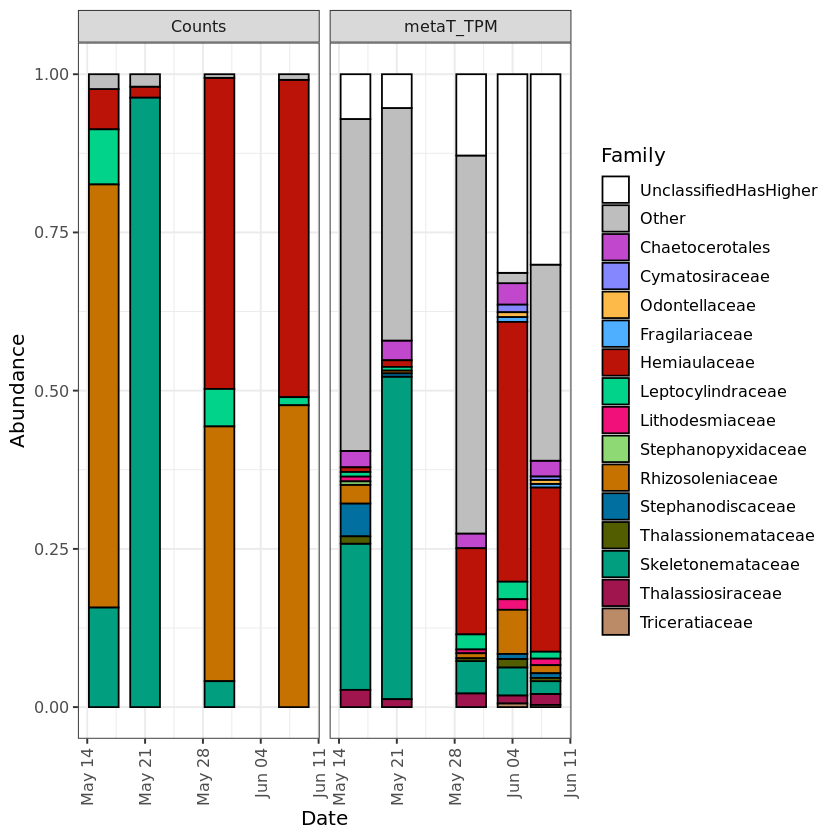

In [162]:
harriet_nb_grouped=data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-Krinos-eukrhythmic/data-output/harriet_nb_grouped.csv"))
distinct_cols=c("#ad007a",
                "#2ac146",
                "#c148cd",
                "#a6d54f",
                "#9962ec",
                "#d0c100",
                "#8587ff",
                "#fdba49",
                "#4eaeff",
                "#bc1308",
                "#02d38a",
                "#f1107a",
                "#8ed974",
                "#ff609a",
                "#006b2b",
                "#ff6434",
                "#01a5cf",
                "#c57200",
                "#0170a1",
                "#c9cc63",
                "#28548a",
                "#525d00",
                "#ff89ba",
                "#019e80",
                "#a0154e",
                "#bb8a66",
                "#8b392a",
                "#ff9e9e","black","white")
all_families = unique(c((harriet_nb_grouped %>% dplyr::filter(Class == "Bacillariophyta"))$Family,
                        (separated_classification_has_higher %>% dplyr::filter(trimws(Class) == "Bacillariophyta"))$Family))
all_families = c(setdiff(all_families,c("Unknown")),"Unknown","Other")

ggplot(link_the_two %>% pivot_longer(cols = c("RelAbund","TPM","NumReads"),
                                    names_to="Type",values_to="Abundance")%>%
       dplyr::group_by(Sample,Date,Class,Family,Type) %>% dplyr::summarize(Abundance=sum(Abundance))%>%
       dplyr::mutate(Family=factor(Family,levels=c("UnclassifiedHasHigher",
                                                   "Other","Non-diatom",
                                                   setdiff(unique(all_families),
                                                           c("UnclassifiedHasHigher",
                                                             "Other","Non-diatom"))))) %>%
      dplyr::mutate(SampleType=factor(case_when(Type=="RelAbund" ~ "Counts",
                              Type=="TPM" ~ "metaT_TPM",
                              Type=="NumReads" ~ "metaT_NumReads"),levels=c("Counts",
                                                                            "metaT_NumReads",
                                                                            "metaT_TPM"))) %>%
      dplyr::filter(SampleType%in%c("Counts","metaT_TPM"))) + 
    geom_bar(aes(x=Date,y=Abundance,fill=Family),color="black",
             position="fill",stat="identity")+facet_wrap(~SampleType,nrow=2)+ 
    scale_fill_manual(values=c("white","gray","yellow",distinct_cols),breaks=c("UnclassifiedHasHigher",
                                                                "Other","Non-diatom",all_families),
                      name="Family") + theme_bw(base_size=12)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

`summarise()` has grouped
output by 'Sample', 'Date',
'Class', 'Family'. You can
override using the `.groups`
argument.
Warning message:
“Removed 44 rows containing
missing values
(`position_stack()`).”


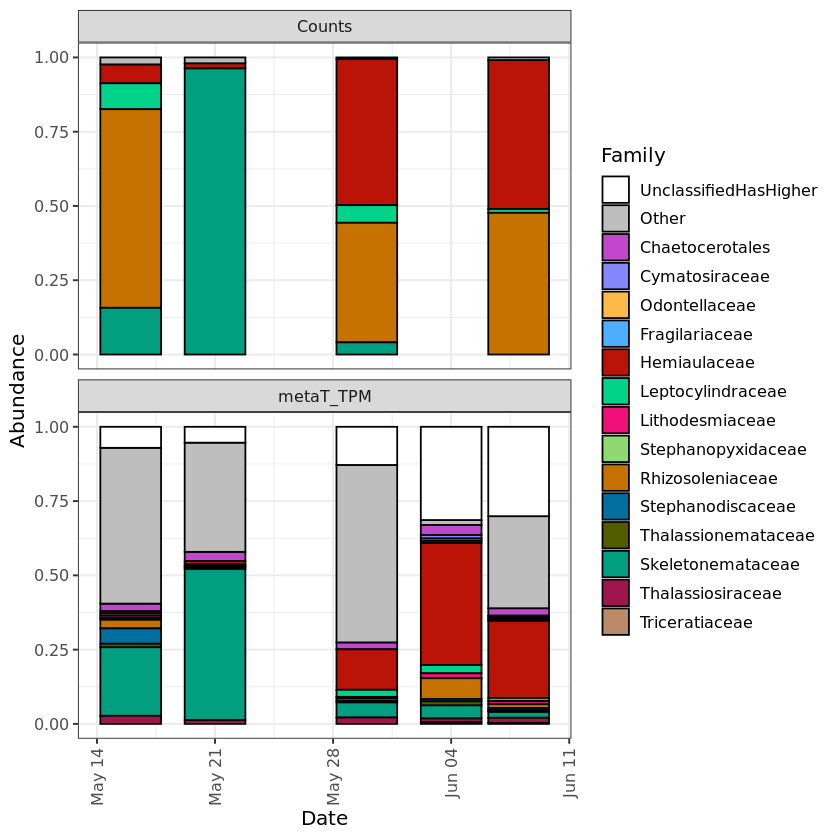

In [167]:
stack_comparison = ggplot(link_the_two %>% pivot_longer(cols = c("RelAbund","TPM","NumReads"),
                                    names_to="Type",values_to="Abundance")%>%
       dplyr::group_by(Sample,Date,Class,Family,Type) %>% dplyr::summarize(Abundance=sum(Abundance))%>%
       dplyr::mutate(Family=factor(Family,levels=c("UnclassifiedHasHigher",
                                                   "Other","Non-diatom",
                                                   setdiff(unique(all_families),
                                                           c("UnclassifiedHasHigher",
                                                             "Other","Non-diatom"))))) %>%
      dplyr::mutate(SampleType=factor(case_when(Type=="RelAbund" ~ "Counts",
                              Type=="TPM" ~ "metaT_TPM",
                              Type=="NumReads" ~ "metaT_NumReads"),levels=c("Counts",
                                                                            "metaT_NumReads",
                                                                            "metaT_TPM"))) %>%
      dplyr::filter(SampleType%in%c("Counts","metaT_TPM"))) + 
    geom_bar(aes(x=Date,y=Abundance,fill=Family),color="black",
             position="fill",stat="identity")+facet_wrap(~SampleType,nrow=2)+ 
    scale_fill_manual(values=c("white","gray","yellow",distinct_cols),breaks=c("UnclassifiedHasHigher",
                                                                "Other","Non-diatom",all_families),
                      name="Family") + theme_bw(base_size=12)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
stack_comparison

In [ ]:
harriet_nb_grouped=data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-Krinos-eukrhythmic/data-output/harriet_nb_grouped.csv"))
distinct_cols=c("#ad007a",
                "#2ac146",
                "#c148cd",
                "#a6d54f",
                "#9962ec",
                "#d0c100",
                "#8587ff",
                "#fdba49",
                "#4eaeff",
                "#bc1308",
                "#02d38a",
                "#f1107a",
                "#8ed974",
                "#ff609a",
                "#006b2b",
                "#ff6434",
                "#01a5cf",
                "#c57200",
                "#0170a1",
                "#c9cc63",
                "#28548a",
                "#525d00",
                "#ff89ba",
                "#019e80",
                "#a0154e",
                "#bb8a66",
                "#8b392a",
                "#ff9e9e","black","white")
all_families = unique(c((harriet_nb_grouped %>% dplyr::filter(Class == "Bacillariophyta"))$Family,
                        (separated_classification_has_higher %>% dplyr::filter(trimws(Class) == "Bacillariophyta"))$Family))
all_families = c(setdiff(all_families,c("Unknown")),"Unknown","Other")

non_target_fams = setdiff(unique(all_families),c("Rhizosoleniaceae","Hemiaulaceae",
                                                 "Thalassiosiraceae","Skeletonemataceae"))
purples_palette = colorRampPalette(brewer.pal(9, "Purples")[3:9])(length(non_target_fams))
stack_comparison = ggplot(link_the_two %>% pivot_longer(cols = c("RelAbund","TPM","NumReads"),
                                    names_to="Type",values_to="Abundance")%>%
       dplyr::filter(Date!="2012-06-04") %>%
       dplyr::group_by(Sample,Date,Class,Family,Type) %>% 
       dplyr::summarize(Abundance=sum(Abundance))%>%
       dplyr::mutate(Family=factor(Family,levels=c("UnclassifiedHasHigher",
                                                   "Other","Non-diatom","Rhizosoleniaceae","Hemiaulaceae",
                                                 "Thalassiosiraceae","Skeletonemataceae",
                                                   setdiff(unique(all_families),
                                                           c("UnclassifiedHasHigher",
                                                             "Other","Non-diatom","Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae"))))) %>%
      dplyr::mutate(SampleType=factor(case_when(Type=="RelAbund" ~ "Counts",
                              Type=="TPM" ~ "metaT_TPM",
                              Type=="NumReads" ~ "metaT_NumReads"),levels=c("Counts",
                                                                            "metaT_NumReads",
                                                                            "metaT_TPM"))) %>%
      dplyr::filter(SampleType%in%c("Counts","metaT_TPM"))) + 
    geom_bar(aes(x=factor(Date),y=Abundance,fill=Family),color="black",
             position="fill",stat="identity")+facet_wrap(~SampleType,nrow=2)+ 
    geom_line(data=link_the_two %>% dplyr::filter(Date!="2012-06-04") %>%
          dplyr::filter(!is.na(Abund)) %>% dplyr::mutate(SampleType="Counts"),
              mapping=aes(x = factor(Date), y = Abund/10^7.2, col=Family,group=Family))+ 
    geom_point(data=link_the_two %>% dplyr::filter(Date!="2012-06-04") %>%
          dplyr::filter(!is.na(Abund))%>% dplyr::mutate(SampleType="Counts"),mapping=aes(x = factor(Date),
                                                                                         y = Abund/10^7.2, 
                                                                                         fill=Family,
                                                                                         group=Family),
               pch=21,size=6,alpha=0.6)+
    scale_fill_manual(values=c("white","gray","#ECCE21","#D87C3F",
                               "#B92921","#630D0D",purples_palette),breaks=c("UnclassifiedHasHigher",
                                                                "Other","Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae",non_target_fams),
                      name="Family") + theme_bw(base_size=12)+ 
    scale_color_manual(values=c("white","gray","#ECCE21","#D87C3F",
                               "#B92921","#630D0D",purples_palette),breaks=c("UnclassifiedHasHigher",
                                                                "Other","Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae",non_target_fams),
                      name="Family") + ylab("Abundance in cells/mL")+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
    scale_y_continuous(
    
    # Features of the first axis
    name = "Relative abundance",
    
    # Add a second axis and specify its features
    sec.axis = sec_axis(~.*10^7.2, name="cells per L")
  ) + xlab("Date")

Warning message:
“Removed 29 rows containing missing values
(`position_stack()`).”
Warning message:
“Removed 29 rows containing missing values
(`position_stack()`).”


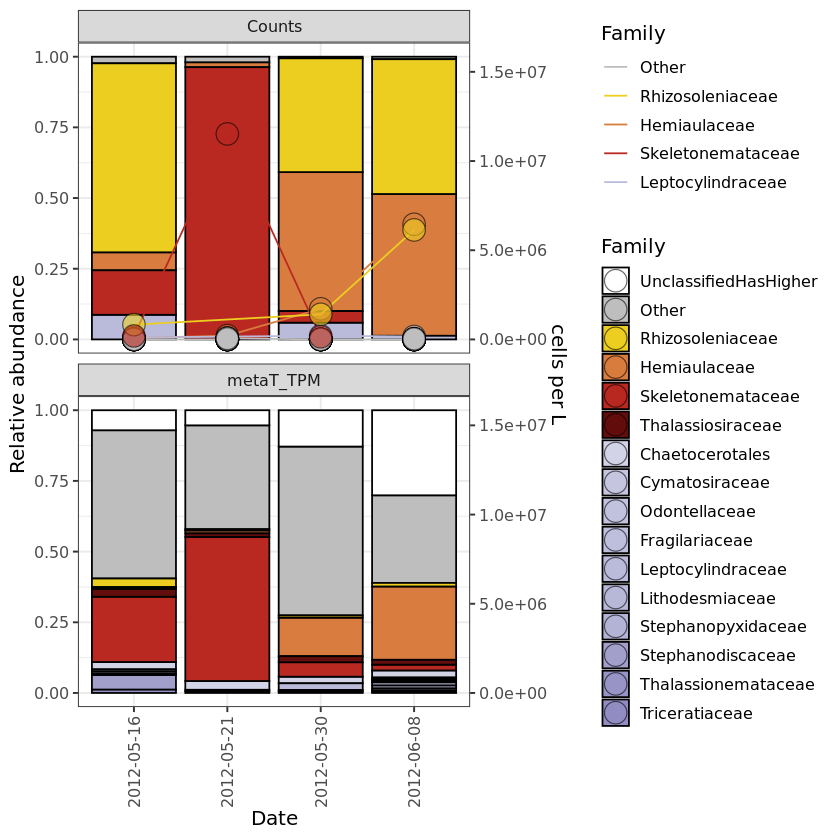

In [57]:
stack_comparison
ggsave("stack_comparison_plot.pdf",width=10,height=8,units="in")

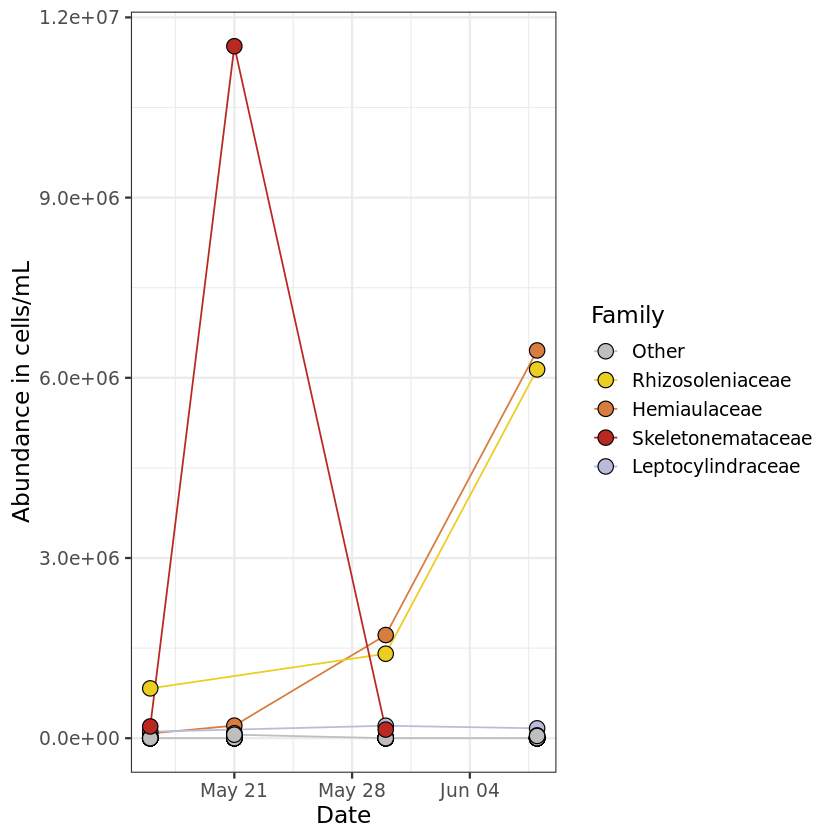

In [27]:
ggplot(link_the_two %>% dplyr::filter(Date!="2012-06-04") %>%
          dplyr::filter(!is.na(Abund))) + geom_line(aes(x = Date, y = Abund, col=Family,group=Family))+ 
    geom_point(aes(x = Date, y = Abund, fill=Family,group=Family),pch=21,size=4)+ 
    scale_fill_manual(values=c("white","gray","#ECCE21","#D87C3F",
                               "#B92921","#630D0D",purples_palette),breaks=c("UnclassifiedHasHigher",
                                                                "Other","Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae",non_target_fams),
                      name="Family")+ 
    scale_color_manual(values=c("white","gray","#ECCE21","#D87C3F",
                               "#B92921","#630D0D",purples_palette),breaks=c("UnclassifiedHasHigher",
                                                                "Other","Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae",non_target_fams),
                      name="Family") + ylab("Abundance in cells/mL") + theme_bw(base_size=14)

`summarise()` has grouped
output by 'Sample', 'Date',
'Class', 'Family'. You can
override using the `.groups`
argument.


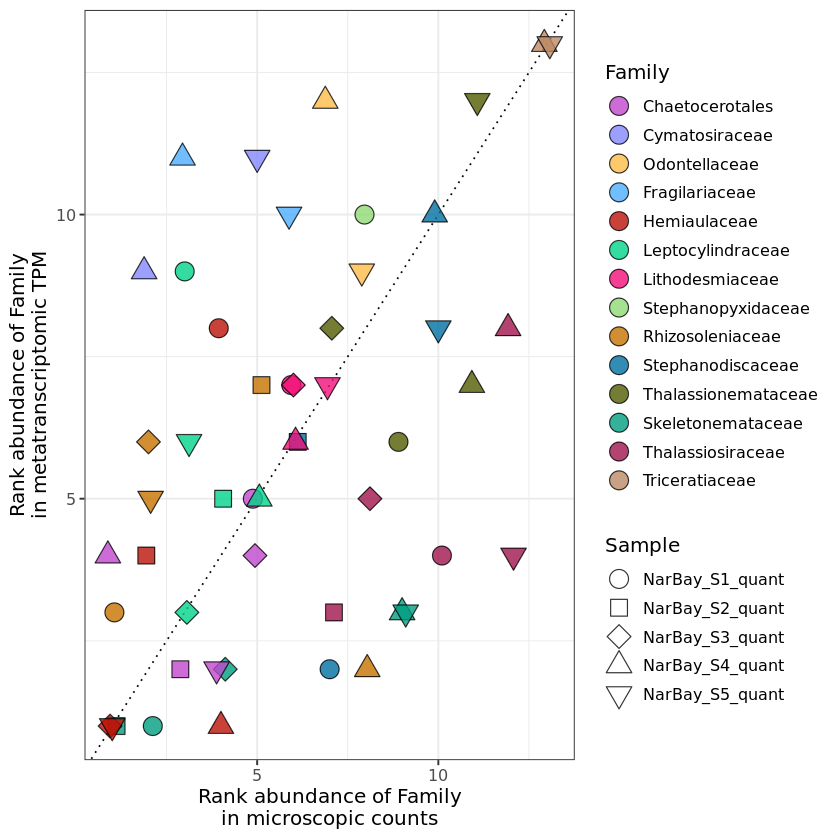

In [166]:
rank_comparison = ggplot(link_the_two %>% pivot_longer(cols = c("RelAbund","TPM","NumReads"),
                                    names_to="Type",values_to="Abundance")%>%
       dplyr::group_by(Sample,Date,Class,Family,Type) %>% dplyr::summarize(Abundance=sum(Abundance))%>%
       dplyr::mutate(Family=factor(Family,levels=c("UnclassifiedHasHigher",
                                                   "Other","Non-diatom",
                                                   setdiff(unique(all_families),
                                                           c("UnclassifiedHasHigher",
                                                             "Other","Non-diatom"))))) %>%
      dplyr::mutate(SampleType=factor(case_when(Type=="RelAbund" ~ "Counts",
                              Type=="TPM" ~ "metaT_TPM",
                              Type=="NumReads" ~ "metaT_NumReads"),levels=c("Counts",
                                                                            "metaT_NumReads",
                                                                            "metaT_TPM"))) %>%
       dplyr::filter(!(Family %in% c("UnclassifiedHasHigher","Other"))) %>%
    group_by(SampleType,Date) %>% 
    mutate(rank = rank(-Abundance)) %>%
    tidyr::pivot_wider(id_cols = c("Sample","Family","Date"),names_from=SampleType,values_from=rank)) + 
    geom_abline(aes(intercept=0,slope=1),linetype="dotted")+ 
    geom_point(aes(x = Counts, y = metaT_TPM, fill = Family,shape=Sample),size=5,alpha=0.8,
               position = position_dodge(width = 0.3)) + 
    scale_shape_manual(values=c(21,22,23,24,25)) + theme_bw(base_size=12) + 
    scale_fill_manual(values=c("white","gray","yellow",distinct_cols),breaks=c("UnclassifiedHasHigher",
                                                                "Other","Non-diatom",all_families))+
    guides(fill = guide_legend(override.aes=list(shape = 21))) + xlab("Rank abundance of Family\nin microscopic counts")+
    ylab("Rank abundance of Family\nin metatranscriptomic TPM")

rank_comparison

In [160]:
link_the_two %>% pivot_longer(cols = c("RelAbund","TPM","NumReads"),
                                    names_to="Type",values_to="Abundance")%>%
       dplyr::group_by(Sample,Date,Class,Family,Type) %>% dplyr::summarize(Abundance=sum(Abundance))%>%
       dplyr::mutate(Family=factor(Family,levels=c("UnclassifiedHasHigher",
                                                   "Other","Non-diatom",
                                                   setdiff(unique(all_families),
                                                           c("UnclassifiedHasHigher",
                                                             "Other","Non-diatom"))))) %>%
      dplyr::mutate(SampleType=factor(case_when(Type=="RelAbund" ~ "Counts",
                              Type=="TPM" ~ "metaT_TPM",
                              Type=="NumReads" ~ "metaT_NumReads"),levels=c("Counts",
                                                                            "metaT_NumReads",
                                                                            "metaT_TPM"))) %>%
    group_by(SampleType,Date) %>% 
    mutate(rank = rank(-Abundance)) %>%
    tidyr::pivot_wider(id_cols = c("Sample","Family","Date"),names_from=SampleType,values_from=rank) %>%
    dplyr::filter(Family=="UnclassifiedHasHigher")

`summarise()` has grouped
output by 'Sample', 'Date',
'Class', 'Family'. You can
override using the `.groups`
argument.


Sample,Family,Date,metaT_NumReads,Counts,metaT_TPM
<chr>,<fct>,<date>,<dbl>,<dbl>,<dbl>
NarBay_S1_quant,UnclassifiedHasHigher,2012-05-16,3,12,3
NarBay_S2_quant,UnclassifiedHasHigher,2012-05-21,3,9,3
NarBay_S3_quant,UnclassifiedHasHigher,2012-05-30,2,10,3
NarBay_S4_quant,UnclassifiedHasHigher,2012-06-04,1,15,2
NarBay_S5_quant,UnclassifiedHasHigher,2012-06-08,1,15,2


### Panel 2: mean percentage identity of diatom non-self hits

Warning message:
“Expected 3 pieces. Additional pieces discarded in 100182 rows [67231127, 67231128, 67231129, 67231130, 67231131, 67231132, 67231133, 67231134, 67231135, 67231136, 67231137, 67231138, 67231139, 67231140, 67231141, 67231142, 67231143, 67231144, 67231145, 67231146, ...].”
Warning message:
“Expected 3 pieces. Additional pieces discarded in 229764 rows [48992, 55128, 55130, 55134, 55135, 55136, 55138, 55140, 55141, 55142, 55143, 55144, 55373, 56463, 56946, 56947, 56948, 56953, 56955, 56956, ...].”
Joining, by = "Family1"
Joining, by = "Family2"
`summarise()` has grouped output by
'Family1'. You can override using the
`.groups` argument.


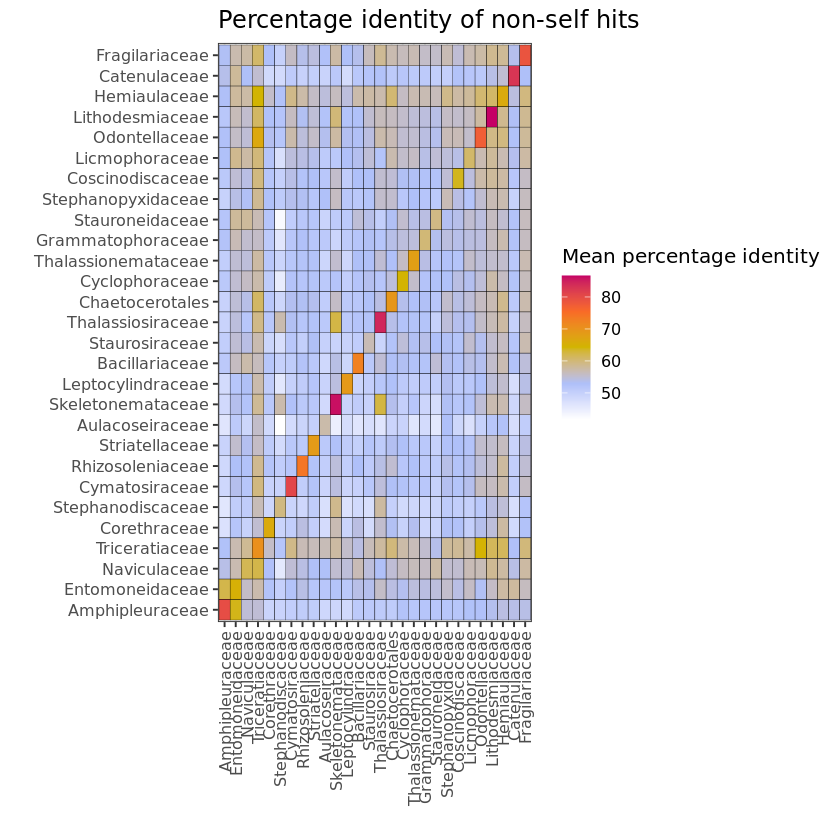

In [14]:
# Now let's read in our bidirectional BLAST search results
bidir_diamond_diatom = data.frame(fread(file.path("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/hits_bidir.diatom.tsv"),
                 header=FALSE,
                 col.names=c("qseqid","sseqid","pident","length","mismatch","gapopen","qstart",
                             "qend","sstart","send","evalue","bitscore")))
tax_table="/vortexfs1/omics/alexander/data/databases/marmmetsp-5Dec2022/tax-table.txt"
tax_table=read.csv(tax_table,sep="\t")
bidir_diamond_diatom_sep = bidir_diamond_diatom %>%
    dplyr::filter(qseqid!=sseqid) %>%
    tidyr::separate(qseqid,sep="_",into=c("CAMPEP","CAMPEPnum1","Source_ID1")) %>%
    tidyr::separate(sseqid,sep="_",into=c("CAMPEP","CAMPEPnum2","Source_ID2"))

bidir_diamond_diatom_join = bidir_diamond_diatom_sep %>%
    dplyr::left_join(tax_table%>%dplyr::select(Source_ID,Domain,Division,
                                               Class,Order,Family) %>%
                     dplyr::rename(c("Domain1"="Domain","Class1"="Class",
                                     "Order1"="Order","Family1"="Family")),
                                   by=c("Source_ID1"="Source_ID"))%>%
    dplyr::left_join(tax_table%>%dplyr::select(Source_ID,Domain,Division,
                                               Class,Order,Family) %>%
                     dplyr::rename(c("Domain2"="Domain","Class2"="Class",
                                     "Order2"="Order","Family2"="Family")),
                                   by=c("Source_ID2"="Source_ID"))
sequential_colors=c('#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529')

diatom_tallied = bidir_diamond_diatom_join %>% 
    dplyr::filter((grepl("Bacillariophy",Class1)&grepl("Bacillariophy",Class2))) %>%
    dplyr::select(CAMPEPnum1,CAMPEPnum2,Family1,Family2,bitscore) %>% 
    dplyr::distinct(CAMPEPnum1,CAMPEPnum2,Family1,Family2,.keep_all=TRUE)%>%
    dplyr::group_by(CAMPEPnum1) %>% dplyr::filter(bitscore==max(bitscore)) %>% dplyr::ungroup() %>%
    dplyr::group_by(Family1,Family2) %>%
    dplyr::tally() %>%
    dplyr::filter(!is.na(Family1)&!is.na(Family2)&(Family1!="")&(Family2!=""))

selected_fams = unique((bidir_diamond_diatom_join %>% dplyr::group_by(Family1) %>%
                       dplyr::tally() %>% dplyr::filter(n > 100000))$Family1)
total_by_fam = bidir_diamond_diatom_join %>% dplyr::distinct(CAMPEPnum1,Family1) %>% 
                    dplyr::group_by(Family1) %>%
                    dplyr::tally()
diatom_tallied_filt = diatom_tallied %>% dplyr::left_join(total_by_fam%>%dplyr::rename(c("n_1"="n"))) %>%
    dplyr::left_join(total_by_fam%>%dplyr::rename(c("n_2"="n","Family2"="Family1"))) %>% rowwise() %>%
    dplyr::mutate(min_seqs = min(n_1,n_2)) %>%
    dplyr::filter((Family1 %in% selected_fams) & (Family2 %in% selected_fams))

diatom_pivoted = diatom_tallied_filt %>% tidyr::pivot_wider(id_cols="Family1",
                                                  names_from="Family2",
                                                  values_from="n")
diatom_pivoted[is.na(diatom_pivoted)] = 0

ord <- hclust( dist(diatom_pivoted %>% dplyr::select(-Family1), 
                    method = "euclidean"), method = "ward.D" )$order

diatom_tallied_filt$Family1 = factor( diatom_tallied_filt$Family1, levels = diatom_pivoted$Family1[ord])
diatom_tallied_filt$Family2 = factor( diatom_tallied_filt$Family2, levels = diatom_pivoted$Family1[ord])


sequential_colors=c("white","#afc0f9","#d2b500","#f96b27","#c50065")

for_heatmap = bidir_diamond_diatom_join %>% 
    dplyr::filter((grepl("Bacillariophy",Class1)&grepl("Bacillariophy",Class2))) %>%
    dplyr::select(CAMPEPnum1,CAMPEPnum2,Family1,Family2,bitscore,pident) %>% 
    dplyr::distinct(CAMPEPnum1,CAMPEPnum2,Family1,Family2,.keep_all=TRUE)%>%
    dplyr::filter(!is.na(Family1)&!is.na(Family2)&(Family1!="")&(Family2!="")) %>%
    dplyr::group_by(CAMPEPnum1) %>% #dplyr::filter(bitscore==max(bitscore)) %>% 
    dplyr::ungroup() %>%
    dplyr::group_by(Family1,Family2) %>% dplyr::summarize(pident=mean(pident)) %>%
    dplyr::filter((Family1!="")&(Family2!=""))

heatmap_pivoted = for_heatmap %>% tidyr::pivot_wider(id_cols="Family1",
                                                  names_from="Family2",
                                                  values_from="pident")

for_ord =as.numeric(as.matrix(heatmap_pivoted %>% dplyr::ungroup() %>% dplyr::select(-Family1)))
#for_ord[is.na(for_ord)] = 0
ord <- hclust( dist(for_ord, 
                    method = "euclidean"), method = "ward.D" )$order

for_heatmap$Family1 = factor( for_heatmap$Family1, levels = heatmap_pivoted$Family1[ord])
for_heatmap$Family2 = factor( for_heatmap$Family2, levels = heatmap_pivoted$Family1[ord])

ggplot(for_heatmap) +
    geom_tile(aes(x = Family1 , y = Family2 , fill = pident),color="black")+
    scale_fill_gradientn(colors=sequential_colors,name="Mean percentage identity")+ 
    theme_bw(base_size=12) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("") + ylab("") + ggtitle("Percentage identity of non-self hits")

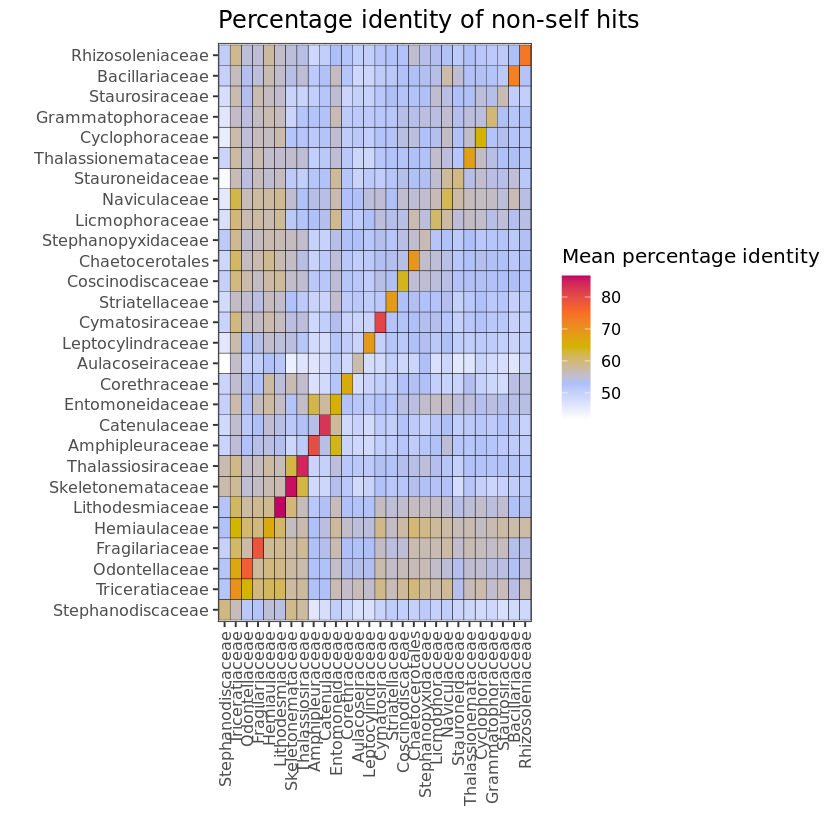

In [18]:
for_ord =as.matrix(heatmap_pivoted %>% dplyr::ungroup() %>% dplyr::select(-Family1))
#for_ord[is.na(for_ord)] = 0
ord <- hclust( dist(for_ord, 
                    method = "euclidean"), method = "median" )$order
ord <- hclust( dist(for_ord, 
                    method = "manhattan"), method = "average" )$order
for_heatmap$Family1 = factor( for_heatmap$Family1, levels = heatmap_pivoted$Family1[ord])
for_heatmap$Family2 = factor( for_heatmap$Family2, levels = heatmap_pivoted$Family1[ord])

pident_plot = ggplot(for_heatmap) +
    geom_tile(aes(x = Family1 , y = Family2 , fill = pident),color="black")+
    scale_fill_gradientn(colors=sequential_colors,name="Mean percentage identity")+ 
    theme_bw(base_size=12) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("") + ylab("") + ggtitle("Percentage identity of non-self hits")
pident_plot

In [58]:
heatmap_pivoted$Family1[ord]

[1] "Stephanodiscaceae"   "Triceratiaceae"      "Odontellaceae"      
 [4] "Fragilariaceae"      "Hemiaulaceae"        "Lithodesmiaceae"    
 [7] "Skeletonemataceae"   "Thalassiosiraceae"   "Amphipleuraceae"    
[10] "Catenulaceae"        "Entomoneidaceae"     "Corethraceae"       
[13] "Aulacoseiraceae"     "Leptocylindraceae"   "Cymatosiraceae"     
[16] "Striatellaceae"      "Coscinodiscaceae"    "Chaetocerotales"    
[19] "Stephanopyxidaceae"  "Licmophoraceae"      "Naviculaceae"       
[22] "Stauroneidaceae"     "Thalassionemataceae" "Cyclophoraceae"     
[25] "Grammatophoraceae"   "Staurosiraceae"      "Bacillariaceae"     
[28] "Rhizosoleniaceae"

## add total number of references for each family to the left of this plot

In [15]:
mmetsp_tax = read.csv("/vortexfs1/omics/alexander/akrinos/remodeling/EUKulele/databases/marmmetsp_better_diatom_taxonomy/tax-table.txt",
         sep="\t")

In [64]:
heatmap_pivoted$Family1[ord]

[1] "Stephanodiscaceae"   "Triceratiaceae"      "Odontellaceae"      
 [4] "Fragilariaceae"      "Hemiaulaceae"        "Lithodesmiaceae"    
 [7] "Skeletonemataceae"   "Thalassiosiraceae"   "Amphipleuraceae"    
[10] "Catenulaceae"        "Entomoneidaceae"     "Corethraceae"       
[13] "Aulacoseiraceae"     "Leptocylindraceae"   "Cymatosiraceae"     
[16] "Striatellaceae"      "Coscinodiscaceae"    "Chaetocerotales"    
[19] "Stephanopyxidaceae"  "Licmophoraceae"      "Naviculaceae"       
[22] "Stauroneidaceae"     "Thalassionemataceae" "Cyclophoraceae"     
[25] "Grammatophoraceae"   "Staurosiraceae"      "Bacillariaceae"     
[28] "Rhizosoleniaceae"

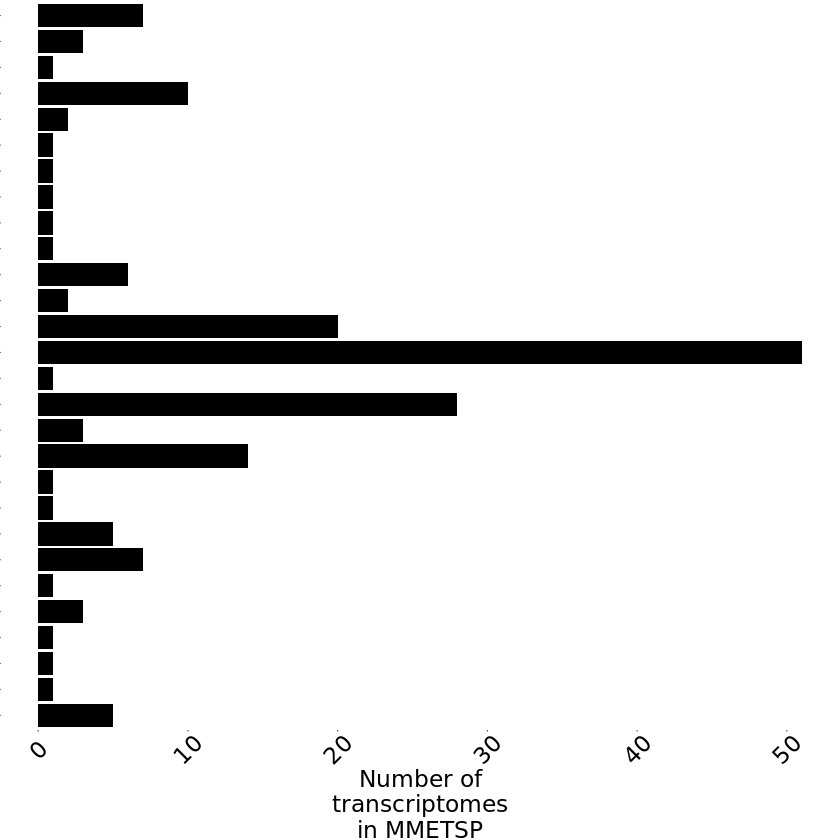

In [16]:
mmetsp_refs_plot = ggplot(mmetsp_tax %>% dplyr::filter(trimws(Class)=="Bacillariophyta") %>%
    dplyr::distinct(Family,Source_ID) %>%
    dplyr::group_by(Family) %>% dplyr::tally()) + 
    geom_bar(aes(x = factor(Family,levels=heatmap_pivoted$Family1[ord]), y = n),
             stat="identity",fill="black")+coord_flip() + theme_void() + 
    scale_x_discrete(breaks=heatmap_pivoted$Family1[ord]) + 
    theme(axis.text.x = element_text(size=14, angle=45),axis.title.x = element_text(size=14),
          axis.ticks = element_line(color="black")) + ylab("Number of\ntranscriptomes\nin MMETSP")
mmetsp_refs_plot

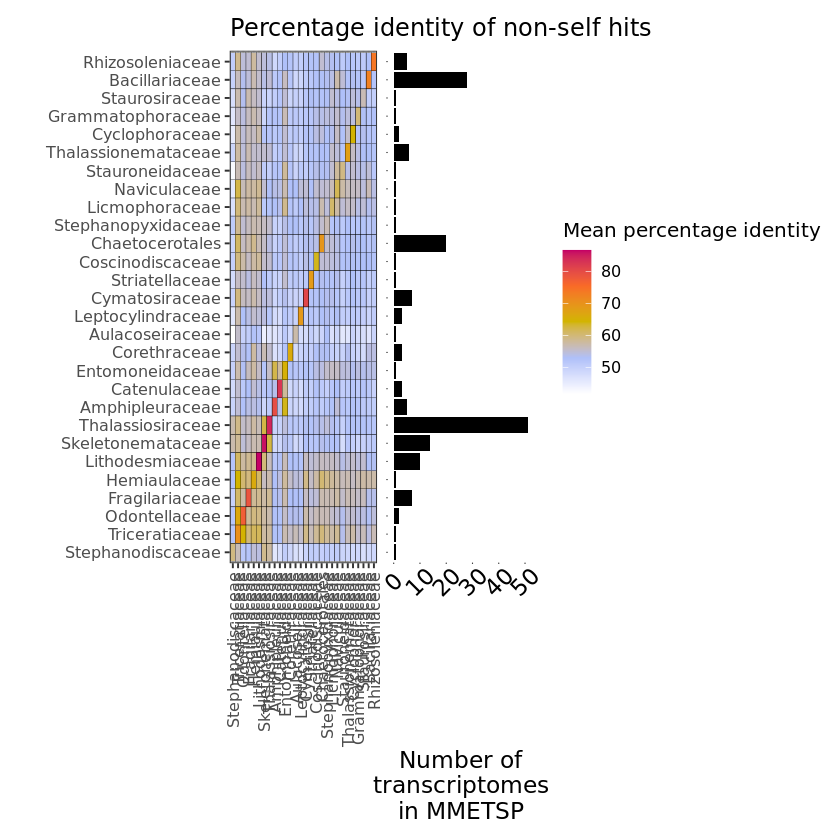

In [19]:
(pident_plot | mmetsp_refs_plot) +
  plot_layout(guides = 'collect')
ggsave("pident_by_mmetsp_refs.pdf",width=12,height=10,units="in")
ggsave("pident_by_mmetsp_refs.png",width=12,height=6,units="in")

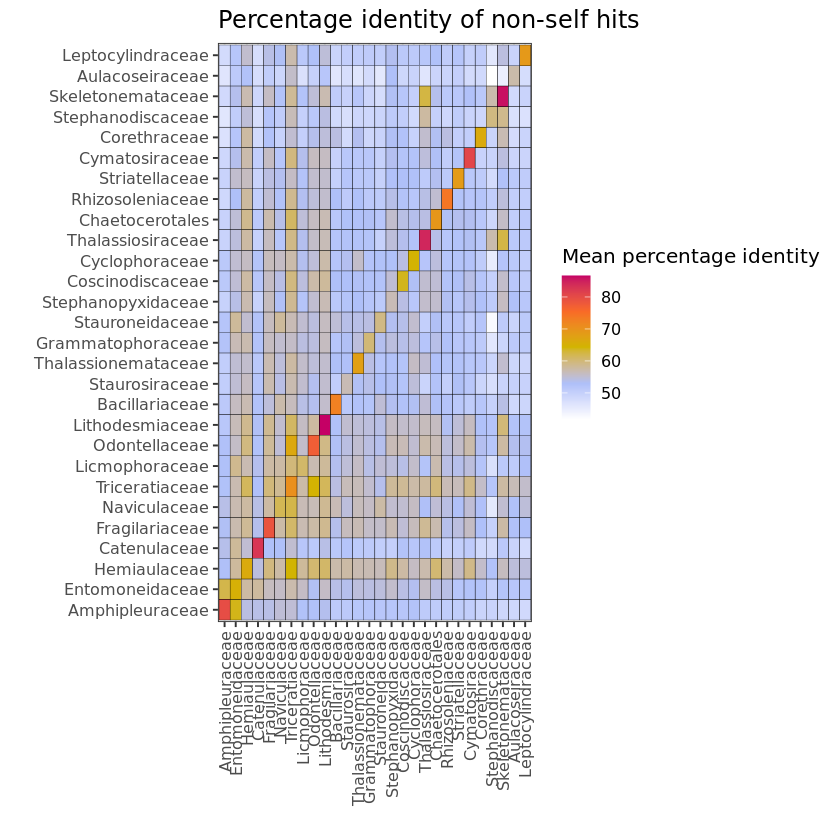

In [46]:
percent_id_plot = ggplot(for_heatmap) +
    geom_tile(aes(x = Family1 , y = Family2 , fill = pident),color="black")+
    scale_fill_gradientn(colors=sequential_colors,name="Mean percentage identity")+ 
    theme_bw(base_size=12) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("") + ylab("") + ggtitle("Percentage identity of non-self hits")

percent_id_plot

In [ ]:
IQR_fr = bidir_diamond_diatom_join %>% 
        dplyr::filter((grepl("Bacillariophy",Class1)&grepl("Bacillariophy",Class2))) %>%
        dplyr::select(CAMPEPnum1,CAMPEPnum2,Family1,Family2,bitscore,pident) %>% 
        dplyr::distinct(CAMPEPnum1,CAMPEPnum2,Family1,Family2,.keep_all=TRUE)%>%
        dplyr::filter(!is.na(Family1)&!is.na(Family2)&(Family1!="")&(Family2!="")) %>%
        dplyr::group_by(CAMPEPnum1) %>% #dplyr::filter(bitscore==max(bitscore)) %>% 
        dplyr::ungroup() %>%
        dplyr::group_by(Family1,Family2)%>% 
        dplyr::summarize(range_pident = quantile(pident,1)-quantile(pident,0))

IQR_fr$Family1 = factor( IQR_fr$Family1, levels = heatmap_pivoted$Family1[ord])
IQR_fr$Family2 = factor( IQR_fr$Family2, levels = heatmap_pivoted$Family1[ord])

IQR_plot = ggplot(IQR_fr) +
    geom_tile(aes(x = Family1 , y = Family2 , fill = range_pident),color="black")+
    scale_fill_gradientn(colors=sequential_colors,name="Mean percentage identity")+ 
    theme_bw(base_size=12) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("") + ylab("") + ggtitle("Percentage identity of non-self hits")

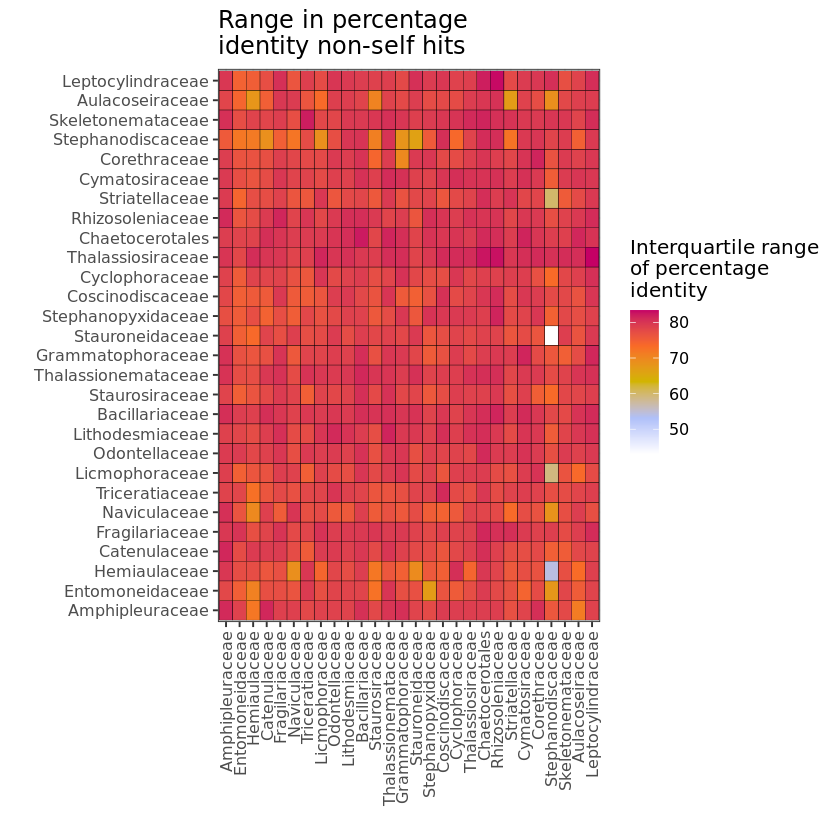

In [101]:
IQR_fr$Family1 = factor( IQR_fr$Family1, levels = heatmap_pivoted$Family1[ord])
IQR_fr$Family2 = factor( IQR_fr$Family2, levels = heatmap_pivoted$Family1[ord])

IQR_plot = ggplot(IQR_fr) +
    geom_tile(aes(x = Family1 , y = Family2 , fill = range_pident),color="black")+
    scale_fill_gradientn(colors=sequential_colors,name="Interquartile range\nof percentage\nidentity")+ 
    theme_bw(base_size=12) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("") + ylab("") + ggtitle("Range in percentage\nidentity non-self hits")
IQR_plot

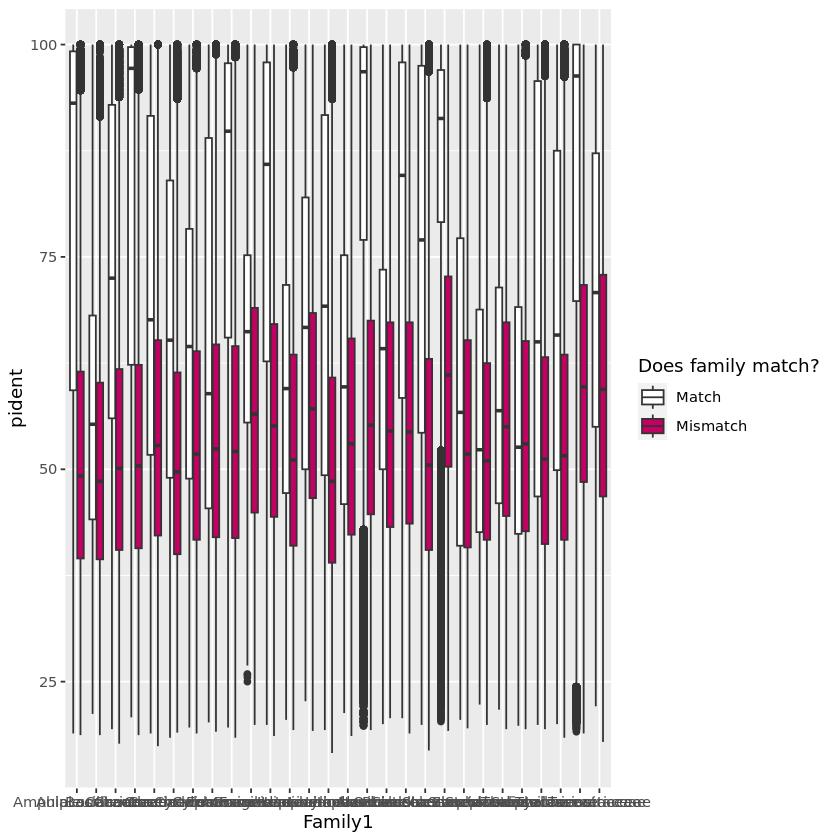

In [102]:
overall_range_plot = bidir_diamond_diatom_join %>% 
        dplyr::filter((grepl("Bacillariophy",Class1)&grepl("Bacillariophy",Class2))) %>%
        dplyr::select(CAMPEPnum1,CAMPEPnum2,Family1,Family2,bitscore,pident) %>% 
        dplyr::distinct(CAMPEPnum1,CAMPEPnum2,Family1,Family2,.keep_all=TRUE)%>%
        dplyr::filter(!is.na(Family1)&!is.na(Family2)&(Family1!="")&(Family2!="")) %>%
        dplyr::group_by(CAMPEPnum1) %>% #dplyr::filter(bitscore==max(bitscore)) %>% 
        dplyr::ungroup() %>%
        dplyr::mutate(family_compare = case_when(Family1==Family2~"Match",
                                                 TRUE ~ "Mismatch"))

ggplot(overall_range_plot) + geom_boxplot(aes(x = Family1, y = pident, fill = family_compare,
                                              group = paste0(Family1,family_compare))) + 
    scale_fill_manual(values=c("white","#c50065"),name="Does family match?")+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

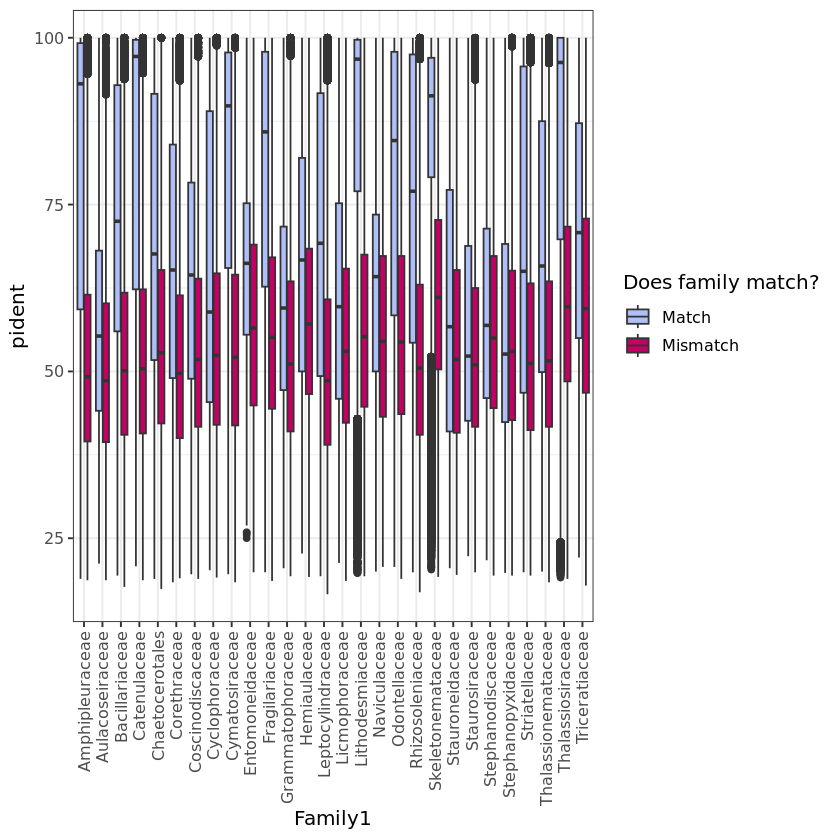

In [110]:
ggplot(overall_range_plot) + geom_boxplot(aes(x = Family1, y = pident, fill = family_compare,
                                              group = paste0(Family1,family_compare))) + 
    scale_fill_manual(values=c("#afc0f9","#c50065"),name="Does family match?")+ theme_bw(base_size=12)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

Picking joint bandwidth of 1.47



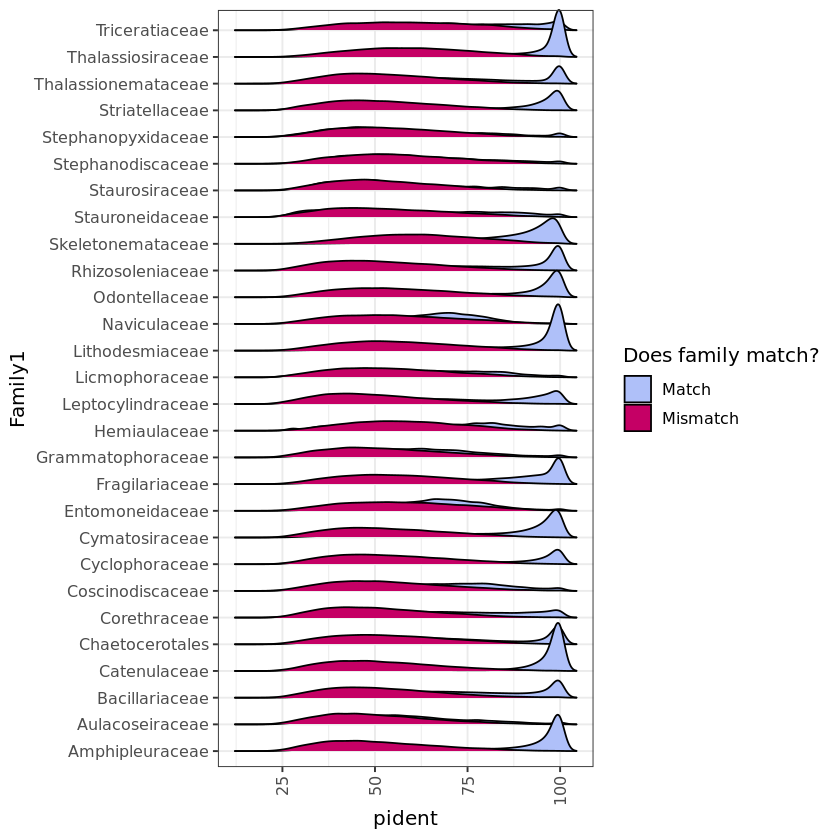

In [111]:
overall_range_distro_plot = ggplot(overall_range_plot) + 
    geom_density_ridges(aes(y = Family1, x = pident, fill = family_compare,
                            group = paste0(Family1,family_compare))) + 
    scale_fill_manual(values=c("#afc0f9","#c50065"),name="Does family match?")+ theme_bw(base_size=12)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

overall_range_distro_plot

### Supplemental Figure: Effect of the LCA permissiveness on proportion of community annotated

In [75]:
taxonomy_estimation_files = Sys.glob("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/eukulele-remap-NB/narragansett-LCA-better-diatom-taxonomy/EUKulele_CAG_marmmetsp_LCA*/taxonomy_estimation/NarBay_S*_merged-estimated-taxonomy.out")

In [77]:
all_eukulele=data.frame()
for (curr_file in taxonomy_estimation_files) {
    LCA_no = unlist(strsplit(curr_file,"EUKulele_CAG_marmmetsp_LCA"))
    LCA_no = unlist(strsplit(LCA_no[length(LCA_no)],"/taxonomy_estimation"))[1]
    sample_name = unlist(strsplit(curr_file,"NarBay_"))
    sample_name = unlist(strsplit(sample_name[length(sample_name)],"_merged"))[1]
    curr_est = data.frame(fread(curr_file,sep="\t")) %>%
        dplyr::select(transcript_name,full_classification) %>%
        tidyr::separate(full_classification, sep=";", into = c("Domain","Supergroup","Phylum",
                                                               "Class","Order","Family","Genus",
                                                               "Species")) %>%
        dplyr::select(transcript_name,Family) %>%
        tidyr::replace_na(list("Family" = "Lineage-Conflicted")) %>%
        dplyr::mutate(Sample = sample_name,LCA_no=LCA_no)
    all_eukulele = all_eukulele %>% dplyr::bind_rows(curr_est)
}

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 1854269 rows [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, ...].”
Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 1631466 rows [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, ...].”
Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 2076766 rows [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, ...].”
Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 800921 rows [2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, ...].”
Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 858304 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, ...].”
Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 1795174 rows [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, ...].”
Warning mes

In [79]:
write.csv(all_eukulele,"lineage_conflicts_LCA_test.csv")

In [21]:
all_eukulele=data.frame(fread("lineage_conflicts_LCA_test.csv"))

Joining, by = "Family"


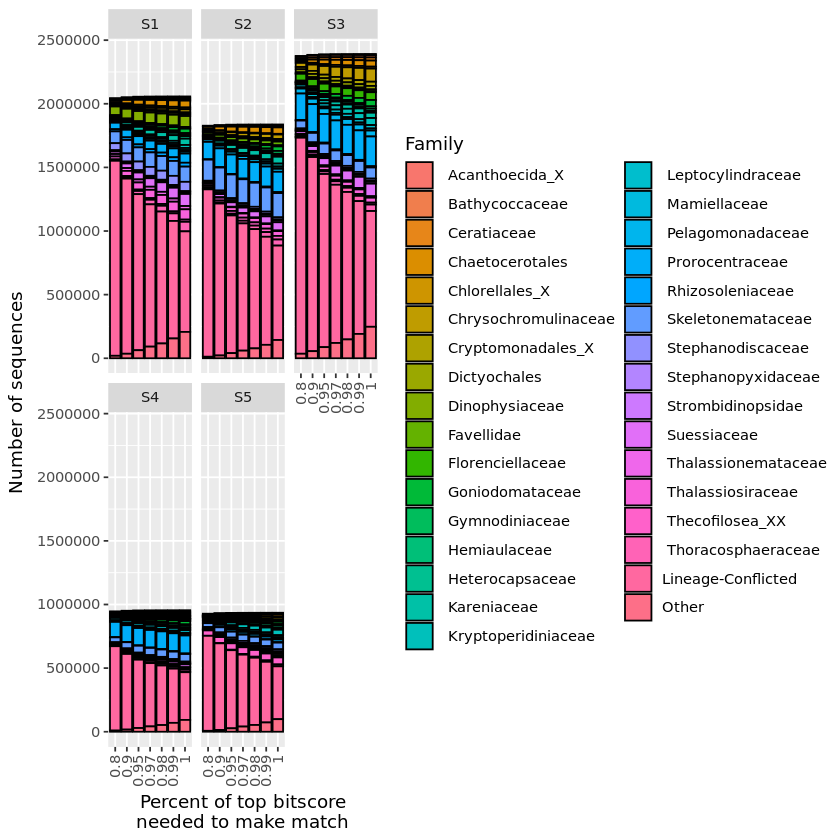

In [78]:
picket_line = all_eukulele %>% dplyr::filter(grepl("S",Sample)) %>%
        dplyr::group_by(Family) %>% dplyr::tally() %>%
        dplyr::filter(n>150000) %>% dplyr::mutate(FamilyRename = Family) %>% dplyr::select(-n)

ggplot(all_eukulele %>% dplyr::filter(grepl("S",Sample)) %>% dplyr::left_join(picket_line) %>%
       dplyr::mutate(Family = case_when(!is.na(FamilyRename) ~ Family,
                                        TRUE ~ "Other")) %>%
        dplyr::group_by(Family,Sample,LCA_no) %>% dplyr::tally()) + 
        geom_bar(aes(x = LCA_no, y = n, fill = Family),color="black",
                 stat = "identity") + facet_wrap(~Sample)+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ylab("Number of sequences")+xlab("Percent of top bitscore\nneeded to make match")

Joining, by = "Family"


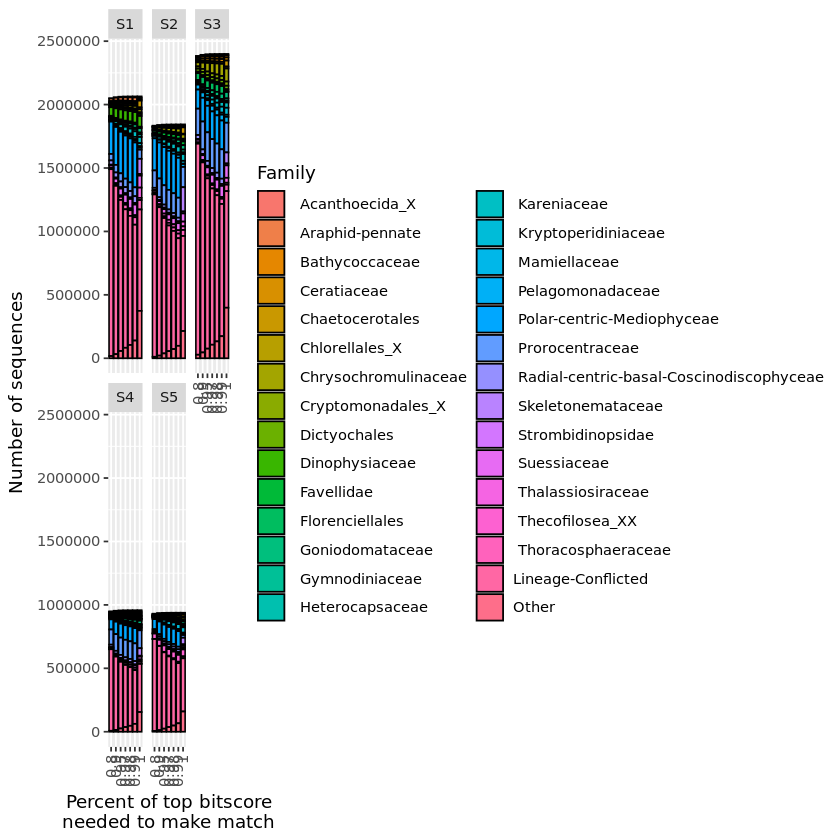

In [31]:
ggplot(all_eukulele %>% dplyr::filter(grepl("S",Sample)) %>% dplyr::left_join(picket_line) %>%
       dplyr::mutate(Family = case_when(!is.na(FamilyRename) ~ Family,
                                        TRUE ~ "Other")) %>%
        dplyr::group_by(Family,Sample,LCA_no) %>% dplyr::tally()) + 
        geom_bar(aes(x = LCA_no, y = n, fill = Family),color="black",
                 stat = "identity") + facet_wrap(~Sample)+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ylab("Number of sequences")+xlab("Percent of top bitscore\nneeded to make match")
ggsave("LCA_effect.png",width=10,height=10,units="in")

In [44]:
all_eukulele %>% dplyr::filter(trimws(Family)=="Skeletonemataceae") %>%
    dplyr::arrange(LCA_no)

V1,transcript_name,Family,Sample,LCA_no
<int>,<chr>,<chr>,<chr>,<dbl>
87094557,megahit_NarBay_A_k51_115873,Skeletonemataceae,A,1
87094594,megahit_NarBay_A_k51_12619,Skeletonemataceae,A,1
87094620,megahit_NarBay_A_k51_130676,Skeletonemataceae,A,1
87094640,megahit_NarBay_A_k51_133706,Skeletonemataceae,A,1
87094646,megahit_NarBay_A_k51_134512,Skeletonemataceae,A,1
87094662,megahit_NarBay_A_k51_136758,Skeletonemataceae,A,1
87094671,megahit_NarBay_A_k51_13851,Skeletonemataceae,A,1
87094692,megahit_NarBay_A_k51_140119,Skeletonemataceae,A,1
87094700,megahit_NarBay_A_k51_141104,Skeletonemataceae,A,1


In [45]:
top_10_fams

Family,n
<chr>,<int>
Polar-centric-Mediophyceae,6202369
Prorocentraceae,4171258
Suessiaceae,1296655
Chrysochromulinaceae,908979
Radial-centric-basal-Coscinodiscophyceae,895126
Thecofilosea_XX,765758
Kareniaceae,756916
Pelagomonadaceae,704164
Dinophysiaceae,688425


In [93]:
all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::group_by(LCA_no,Family,Sample) %>% dplyr::tally() %>% dplyr::arrange(desc(Family),Sample)

LCA_no,Family,Sample,n
<chr>,<chr>,<chr>,<int>
0.8,Skeletonemataceae,S1,92743
0.9,Skeletonemataceae,S1,105449
0.95,Skeletonemataceae,S1,111241
0.97,Skeletonemataceae,S1,113668
0.98,Skeletonemataceae,S1,115127
0.99,Skeletonemataceae,S1,117072
1,Skeletonemataceae,S1,119280
0.8,Skeletonemataceae,S2,165978
0.9,Skeletonemataceae,S2,180598


In [103]:
unique((all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::group_by(LCA_no,Family,Sample) %>% dplyr::tally())$Family)

[1] " Hemiaulaceae"      " Rhizosoleniaceae"  " Skeletonemataceae"

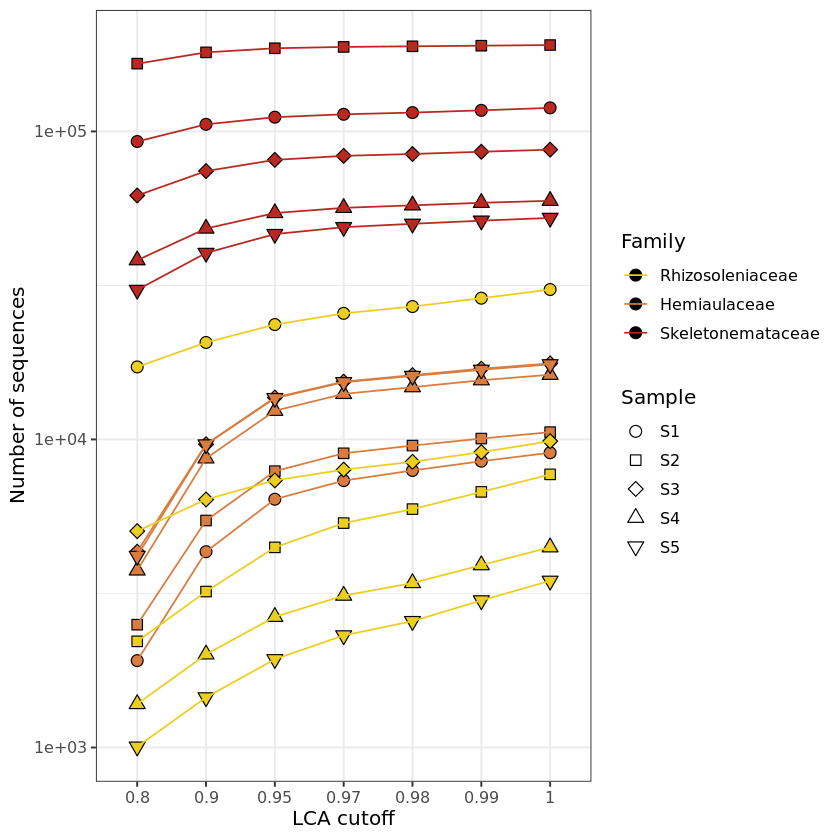

In [104]:
ggplot(all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::group_by(LCA_no,Family,Sample) %>% dplyr::tally()) + 
    geom_point(aes(x = LCA_no, y = n, fill =trimws(Family),shape=Sample),size=3) + 
    geom_line(aes(x = LCA_no, y = n, color=trimws(Family),group=paste0(Family,Sample))) + 
    scale_fill_manual(values=c("#ECCE21","#D87C3F",
                               "#B92921","#630D0D"),breaks=c("Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae"),
                      name="Family")+ 
    scale_color_manual(values=c("#ECCE21","#D87C3F",
                               "#B92921","#630D0D"),breaks=c("Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae"),
                      name="Family")+ 
    scale_shape_manual(values=c(21,22,23,24,25)) + scale_y_log10() + theme_bw(base_size=12) + 
    xlab("LCA cutoff") + ylab("Number of sequences")

In [ ]:
ggplot(all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::group_by(LCA_no,Family,Sample) %>% dplyr::tally()) + 
    geom_boxplot(aes(x = LCA_no, y = n, fill =trimws(Family))) + 
    scale_fill_manual(values=c("#ECCE21","#D87C3F",
                               "#B92921","#630D0D"),breaks=c("Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae"),
                      name="Family")+ 
    scale_color_manual(values=c("#ECCE21","#D87C3F",
                               "#B92921","#630D0D"),breaks=c("Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae"),
                      name="Family")+ 
    scale_shape_manual(values=c(21,22,23,24,25)) + scale_y_log10() + theme_bw(base_size=12) + 
    xlab("LCA cutoff") + ylab("Number of sequences")

In [ ]:
ggplot(all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::group_by(LCA_no,Family) %>% dplyr::tally()) + 
    geom_point(aes(x = LCA_no, y = n, fill =Family)) + 
    geom_line(aes(x = LCA_no, y = n, color=Family,group=paste0(Family))) + 
    scale_fill_manual(values=c(21,22,23)) + facet_wrap(~Family) + scale_y_log10()



In [116]:
all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::group_by(LCA_no,Family,Sample) %>% dplyr::tally() %>% dplyr::ungroup() %>%
    dplyr::group_by(LCA_no,Family) %>%
    dplyr::summarize(stdn=sd(n,na.rm=T),n=mean(n))


`summarise()` has grouped output by
'LCA_no'. You can override using the
`.groups` argument.


LCA_no,Family,stdn,n
<chr>,<chr>,<dbl>,<dbl>
0.8,Hemiaulaceae,1070.843,3336.8
0.8,Rhizosoleniaceae,6799.756,5367.8
0.8,Skeletonemataceae,54881.320,77891.0
0.9,Hemiaulaceae,2491.014,7547.8
0.9,Rhizosoleniaceae,8004.727,6739.6
0.9,Skeletonemataceae,56767.439,89825.4
0.95,Hemiaulaceae,3414.220,10795.6
0.95,Rhizosoleniaceae,8970.495,8005.0
0.95,Skeletonemataceae,56556.503,95818.8


In [130]:
all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::mutate(Family = trimws(Family)) %>%
    dplyr::group_by(LCA_no,Family,Sample) %>% dplyr::tally() %>%
    tidyr::pivot_wider(id_cols = c("LCA_no","Sample"),names_from = "Family",values_from=n) %>%
    dplyr::mutate(RhizoRatio = Rhizosoleniaceae/Hemiaulaceae)

LCA_no,Sample,Hemiaulaceae,Rhizosoleniaceae,Skeletonemataceae,RhizoRatio
<chr>,<chr>,<int>,<int>,<int>,<dbl>
0.8,S1,1914,17199,92743,8.9858934
0.8,S2,2504,2211,165978,0.8829872
0.8,S3,4321,5039,61961,1.1661652
0.8,S4,3758,1384,38187,0.3682810
0.8,S5,4187,1006,30586,0.2402675
0.9,S1,4321,20645,105449,4.7778292
0.9,S2,5457,3208,180598,0.5878688
0.9,S3,9646,6385,74367,0.6619324
0.9,S4,8682,2006,48394,0.2310528


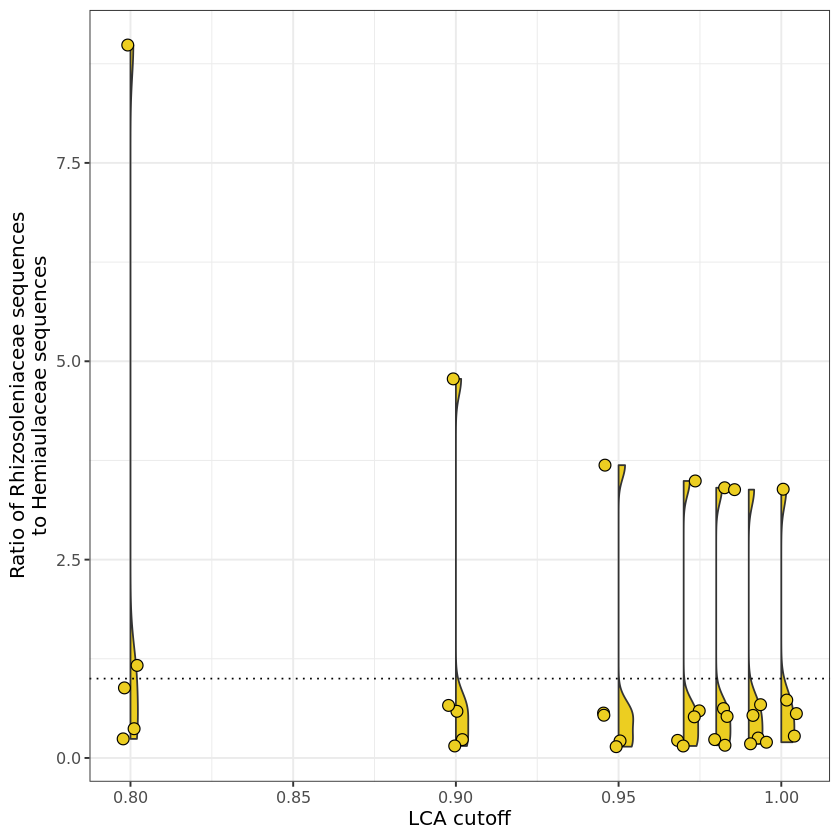

In [26]:
violinswarm=ggplot(all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::mutate(Family = trimws(Family)) %>%
    dplyr::group_by(LCA_no,Family,Sample) %>% dplyr::tally() %>%
    tidyr::pivot_wider(id_cols = c("LCA_no","Sample"),names_from = "Family",values_from=n) %>%
    dplyr::mutate(RhizoRatio = Rhizosoleniaceae/Hemiaulaceae)) + 
    geom_violinhalf(aes(x = LCA_no, y = RhizoRatio,group=LCA_no),fill="#ECCE21")+
    geom_point(aes(x = LCA_no, y = RhizoRatio),fill="#ECCE21",pch=21,size=3, 
               position = position_jitter(w = 0.005, h = 0))+
    #geom_boxplot(aes(x = LCA_no, y = RhizoRatio),fill="transparent",width=0.3)+
    theme_bw(base_size=12) + 
    xlab("LCA cutoff") + ylab("Ratio of Rhizosoleniaceae sequences\nto Hemiaulaceae sequences") + 
    guides(fill = guide_legend(override.aes= list(shape = 21))) + 
    geom_hline(aes(yintercept=1),linetype="dotted")
violinswarm

`summarise()` has grouped output by
'LCA_no'. You can override using the
`.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will
replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will
replace the existing scale.


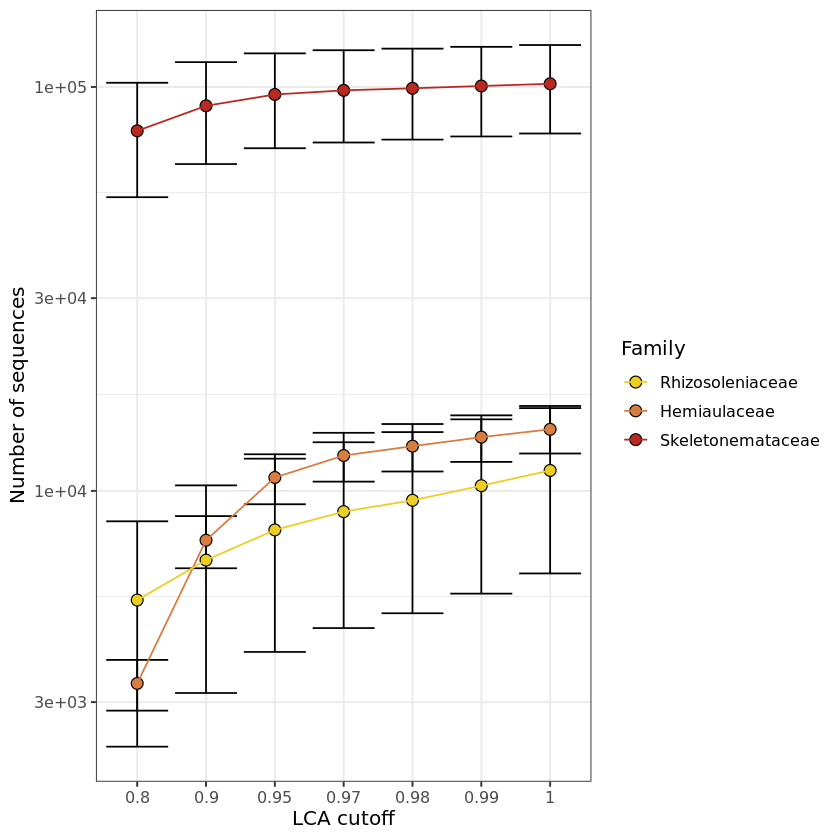

In [121]:
ggplot(all_eukulele %>% dplyr::filter(trimws(Family)%in%c("Skeletonemataceae",
                                                   "Rhizosoleniaceae",
                                                   "Hemiaulaceae")) %>%
    dplyr::group_by(LCA_no,Family,Sample) %>% dplyr::tally() %>% dplyr::ungroup() %>%
    dplyr::group_by(LCA_no,Family) %>%
    dplyr::summarize(stdn=sd(n,na.rm=T)/sqrt(length(n)),n=mean(n))) + 
    geom_errorbar(aes(x = LCA_no, ymin = n-stdn, ymax = n+stdn))+ 
    geom_point(aes(x = LCA_no, y = n, fill =trimws(Family)),size=3,pch=21)+ 
    geom_line(aes(x = LCA_no, y = n, color=trimws(Family),group=paste0(Family))) + 
    scale_fill_manual(values=c(21,22,23)) + scale_y_log10()+ 
    scale_fill_manual(values=c("#ECCE21","#D87C3F",
                               "#B92921","#630D0D"),breaks=c("Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae"),
                      name="Family")+ 
    scale_color_manual(values=c("#ECCE21","#D87C3F",
                               "#B92921","#630D0D"),breaks=c("Rhizosoleniaceae","Hemiaulaceae",
                                                 "Skeletonemataceae","Thalassiosiraceae"),
                      name="Family")+ 
    scale_shape_manual(values=c(21,22,23,24,25)) + scale_y_log10() + theme_bw(base_size=12) + 
    xlab("LCA cutoff") + ylab("Number of sequences") + 
    guides(fill = guide_legend(override.aes= list(shape = 21)))

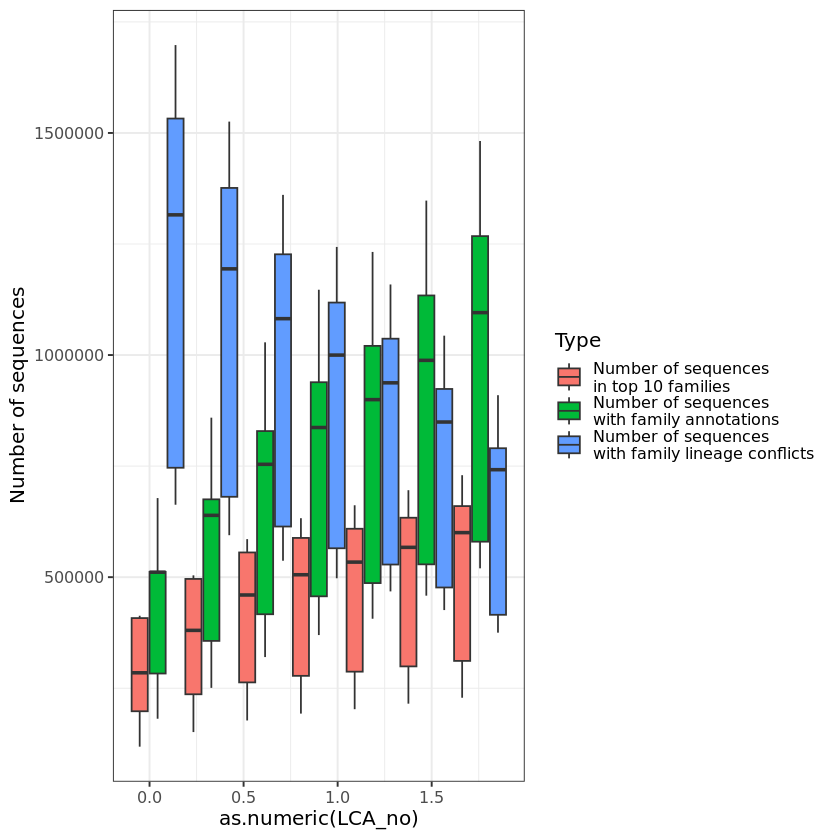

In [80]:
top_10_fams = all_eukulele %>% dplyr::filter(grepl("S",Sample)) %>%
    dplyr::filter(Family!="Lineage-Conflicted") %>%
    dplyr::group_by(Family) %>% dplyr::tally() %>%
    slice_max(n, n=10)

num_in_top_10 = all_eukulele %>% dplyr::filter(Family %in% unique(top_10_fams$Family)) %>%
    dplyr::group_by(Sample,LCA_no) %>% dplyr::tally() %>%
    dplyr::mutate(Type="Number of sequences\nin top 10 families")

top_5_fams = all_eukulele %>% dplyr::filter(grepl("S",Sample)) %>%
    dplyr::filter(Family!="Lineage-Conflicted") %>%
    dplyr::group_by(Family) %>% dplyr::tally() %>%
    slice_max(n, n=5)


num_in_top_5 = all_eukulele %>% dplyr::filter(Family %in% unique(top_5_fams$Family)) %>%
    dplyr::group_by(Sample,LCA_no) %>% dplyr::tally() %>%
    dplyr::mutate(Type="Number of sequences\nin top 5 families")

num_lineage_conflicted = all_eukulele %>% dplyr::filter(Family == "Lineage-Conflicted") %>%
    dplyr::group_by(Sample,LCA_no) %>% dplyr::tally() %>%
    dplyr::mutate(Type="Number of sequences\nwith family lineage conflicts")

num_not_lineage_conflicted = all_eukulele %>% dplyr::filter(Family != "Lineage-Conflicted") %>%
    dplyr::group_by(Sample,LCA_no) %>% dplyr::tally() %>%
    dplyr::mutate(Type="Number of sequences\nwith family annotations")

ggplot(num_in_top_10 %>% dplyr::bind_rows(num_lineage_conflicted) %>%
       dplyr::bind_rows(num_not_lineage_conflicted)) + 
    geom_boxplot(aes(x = as.numeric(LCA_no), y = n,fill=Type,group=paste0(Type,LCA_no)),width=2) + 
    ylab("Number of sequences") + theme_bw(base_size=12)

In [81]:
bottom_50_fams = all_eukulele %>% dplyr::filter(grepl("S",Sample)) %>%
    dplyr::group_by(Family) %>% dplyr::tally() %>%
    slice_min(n, n=100)

num_in_bottom_50 = all_eukulele %>% dplyr::filter(Family %in% unique(bottom_50_fams$Family)) %>%
    dplyr::group_by(Sample,LCA_no) %>% dplyr::tally() %>%
    dplyr::mutate(Type="Number of sequences\nin bottom 50 families")

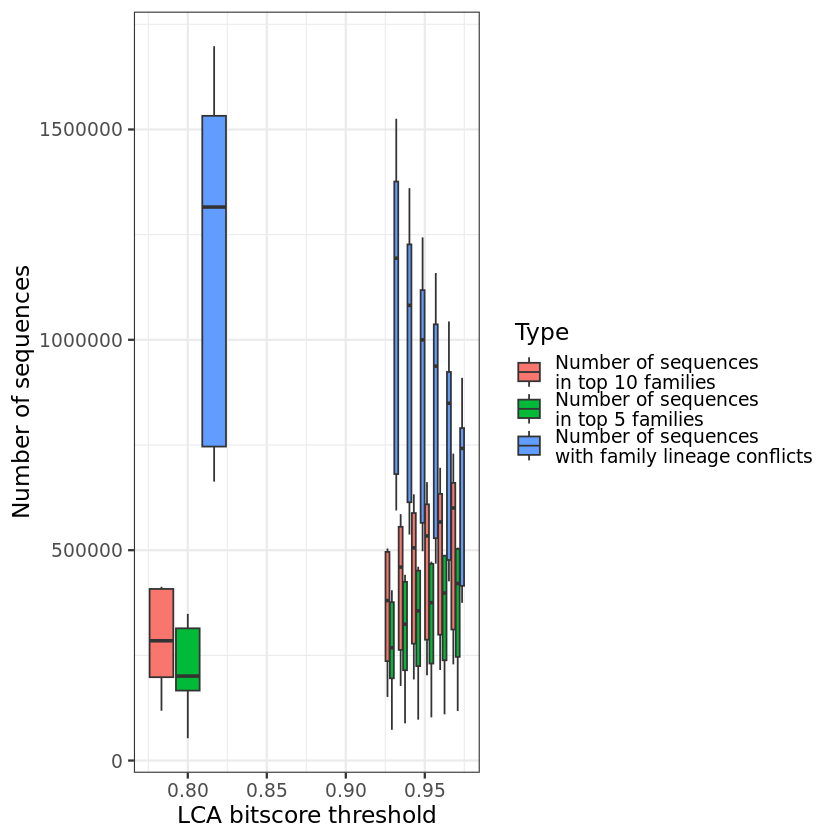

In [82]:
ggplot(num_in_top_10 %>% dplyr::bind_rows(num_lineage_conflicted) %>% dplyr::bind_rows(num_in_top_5)) + 
    geom_boxplot(aes(x = as.numeric(LCA_no), y = n,fill=Type,group=paste0(Type,LCA_no)),width=0.05) + 
    ylab("Number of sequences") + theme_bw(base_size=14) + xlab("LCA bitscore threshold")

ggsave("bitscore_LCA_relationship.png",width=7,height=7,units="in")

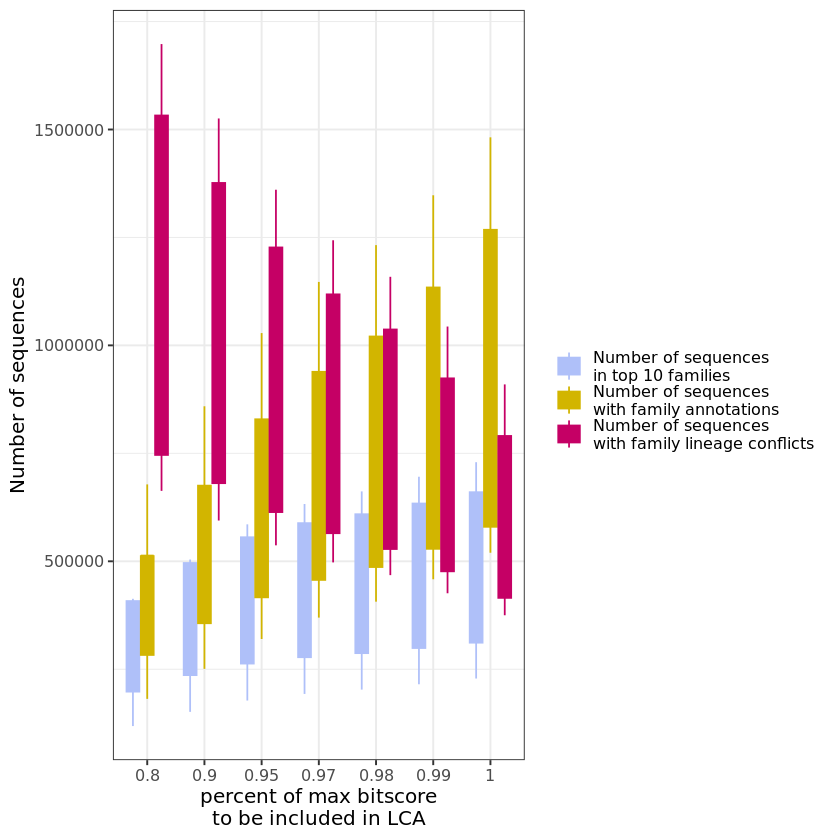

In [83]:

lca_relationship = ggplot(num_in_top_10 %>% dplyr::bind_rows(num_lineage_conflicted) %>%
       dplyr::bind_rows(num_not_lineage_conflicted)) + 
    geom_boxplot(aes(x = LCA_no, y = n,fill=Type,group=paste0(Type,LCA_no),color=Type)) + 
    ylab("Number of sequences") + theme_bw(base_size=12) + 
    xlab("percent of max bitscore\nto be included in LCA")+ 
    scale_fill_manual(values=c("#afc0f9","#d2b500","#c50065"),name="")+ 
    scale_color_manual(values=c("#afc0f9","#d2b500","#c50065"),name="")
lca_relationship

In [1]:
lca_families = ggplot(all_eukulele %>% dplyr::distinct(Sample,LCA_no,Family) %>%
       dplyr::group_by(Sample,LCA_no) %>%
       dplyr::tally()) + geom_boxplot(aes(x = LCA_no, y = n,group=LCA_no)) + 
    theme_bw(base_size=13) + 
    xlab("percent of max bitscore\nto be included in LCA")+ 
    ylab("Number of families identified")

lca_families

ERROR: Error in ggplot(all_eukulele %>% dplyr::distinct(Sample, LCA_no, Family) %>% : could not find function "ggplot"


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


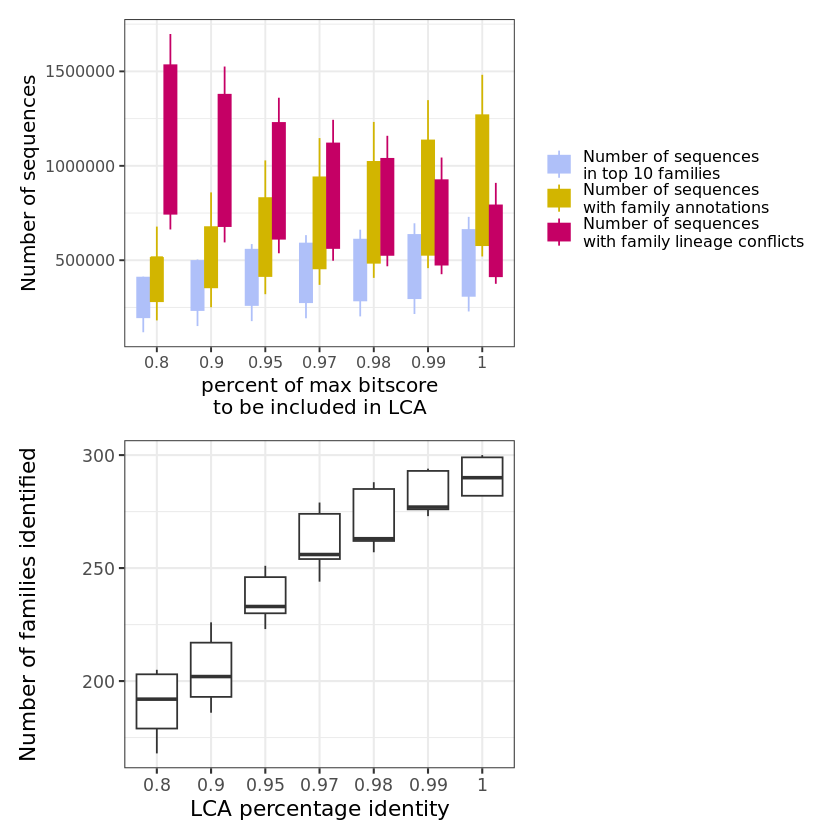

In [85]:
lca_relationship/lca_families
ggsave("lca_relationships.pdf")
ggsave("lca_relationships.png")

Warning message:
“Removed 44 rows containing
missing values
(`position_stack()`).”
Warning message:
“Removed 44 rows containing
missing values
(`position_stack()`).”


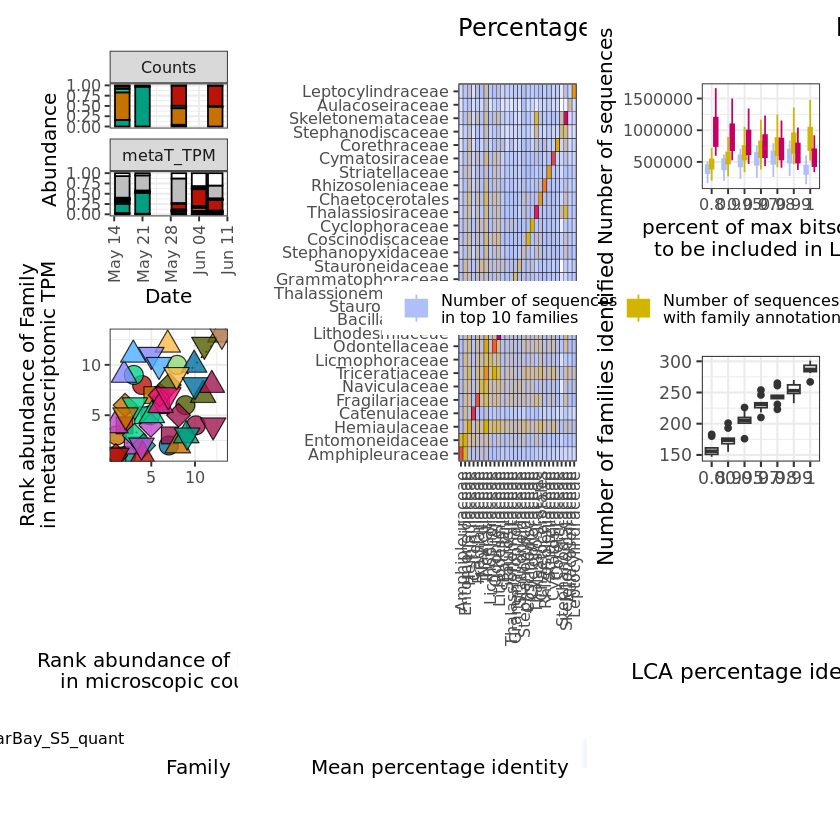

In [180]:
((stack_comparison +theme(legend.position="none"))/ (rank_comparison+theme(legend.position="bottom"))) | 
    pident_plot+theme(legend.position="bottom") | ((lca_relationship+theme(legend.position="bottom"))/ 
                                                   (lca_families+theme(legend.position="bottom")))

ggsave("diatom_fig4.pdf",width=14,height=12,units="in")

## Collate the final figure

Warning message:
“Removed 44 rows containing missing values
(`position_stack()`).”
Warning message:
“Removed 44 rows containing missing values
(`position_stack()`).”


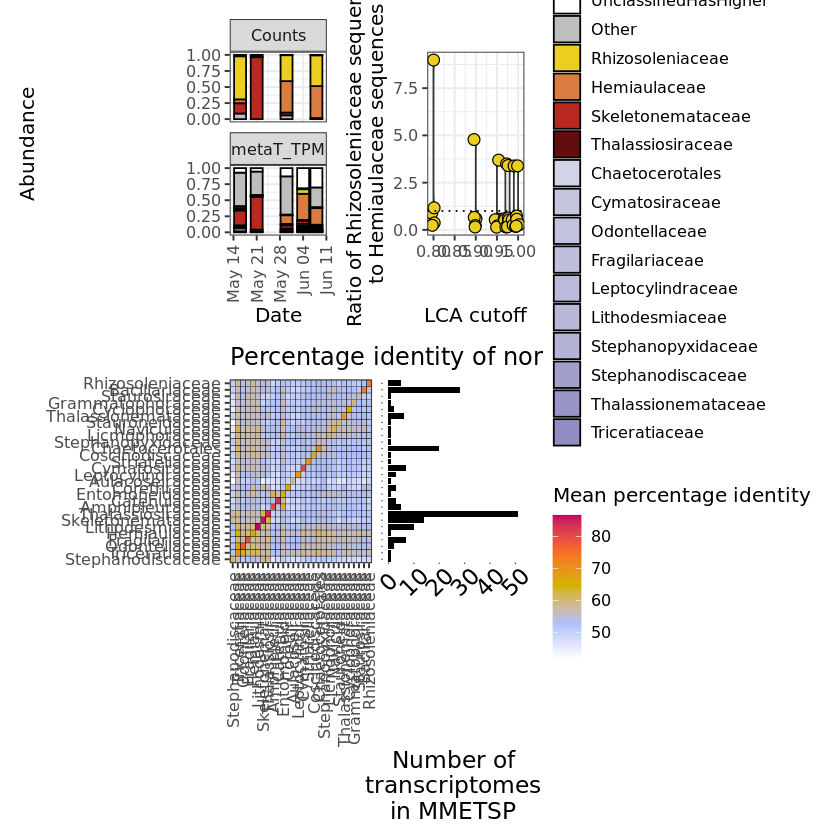

In [27]:
(stack_comparison|violinswarm)/(pident_plot | mmetsp_refs_plot)+
  plot_layout(guides = 'collect')

ggsave("diatom_fig4_revised.pdf",width=14,height=12,units="in")